# 3.2-Clustering and further filtering

**Inés Sentís**

Date of execution 

In [1]:
Sys.Date()

[1] "2025-01-09"

## Introduction

Remove further cells and re-do normalization embeddings and clustering

In [2]:
timepoint <- "T2"

## Libraries

In [3]:
suppressMessages(suppressWarnings({
library(Seurat)
library(here)
library(glue)
library(tidyverse)
library(grid)
library(gridExtra)
library(ggplot2)
library(harmony)
library(scater) 
library(scran)
}))

## Parameters

In [4]:
#dr_here(show_reason = TRUE)
source(here("SCGRES_83_84/sc_analysis/misc/paths.R"))
source(here("utils/bin.R"))

set.seed(0)

## Load data

In [5]:
seurat_obj <- readRDS(here(glue("{clust}/{robj_dir}/dimred_combined_object_{timepoint}.rds")))

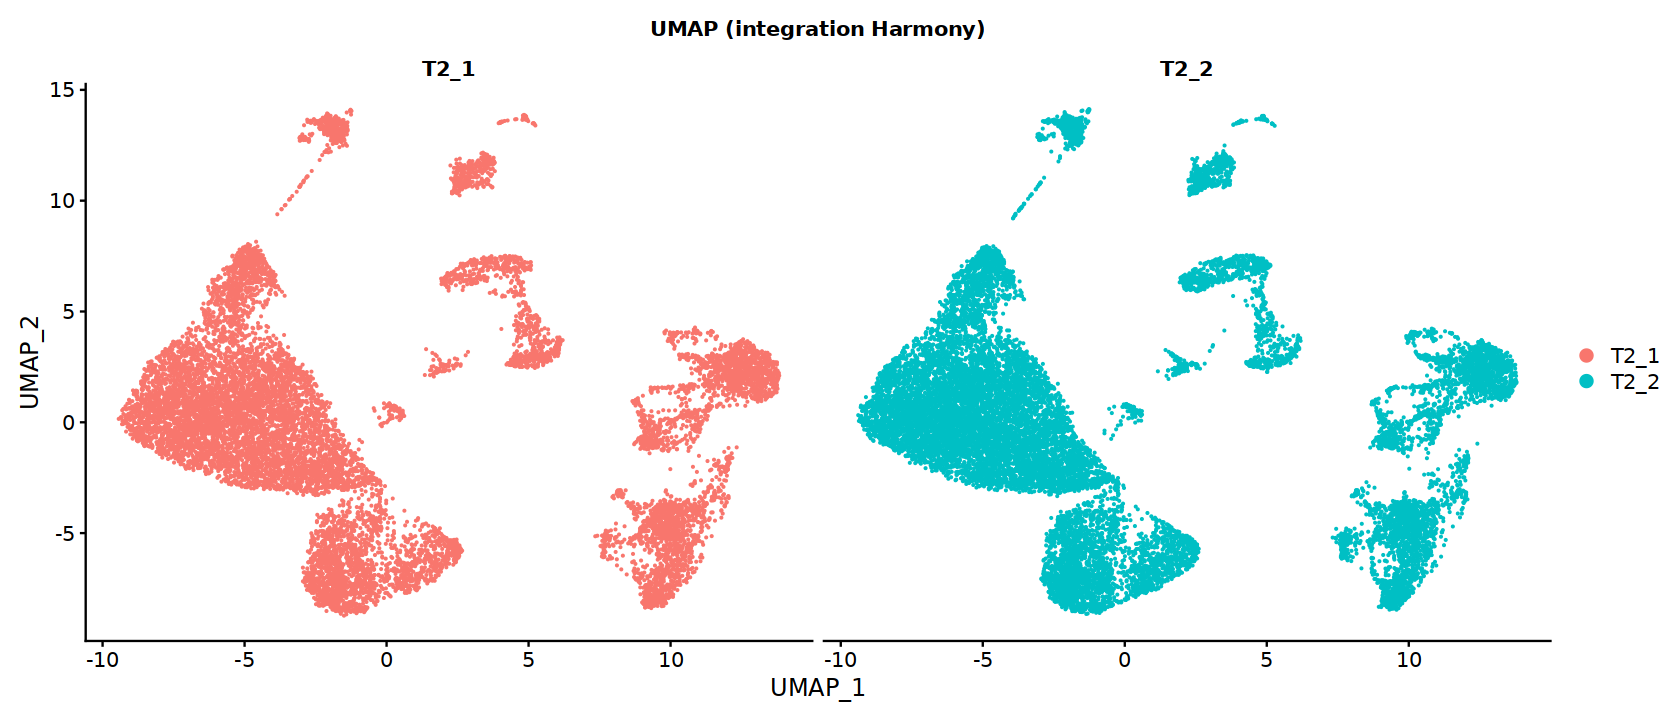

In [6]:
options(repr.plot.width = 14, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(
  seurat_obj,
  reduction = "umap",
  group.by = "sample_id",
  split.by = "sample_id",
  pt.size = 0.1
) + ggtitle('UMAP (integration Harmony)') + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

## Remove potential erythrocytes

In [7]:
seurat_obj <- subset(x = seurat_obj, subset = HBM == 0 & HEMGN == 0 & HBG2 == 0)

In [8]:
seurat_obj <- DietSeurat(
  seurat_obj,
  counts = TRUE,
  data = TRUE,
  scale.data = FALSE,
  features = NULL,
  assays = NULL,
  dimreducs = FALSE,
  graphs = NULL
)

In [9]:
print(table(rowSums(as.matrix(seurat_obj[['RNA']]@counts)) == 0))
  
keep_genes <- data.frame(rowSums(as.matrix(seurat_obj[['RNA']]@counts)) != 0)
colnames(keep_genes) <- "logical"
keep_genes <- subset(keep_genes, logical==TRUE)
seurat_obj[['RNA']]@counts <- seurat_obj[['RNA']]@counts[rownames(keep_genes), ]
seurat_obj[['RNA']]@data <- seurat_obj[['RNA']]@data[rownames(keep_genes), ]
seurat_obj


FALSE  TRUE 
29184   682 


An object of class Seurat 
29184 features across 26610 samples within 1 assay 
Active assay: RNA (29184 features, 0 variable features)

### Re-do embedding

In [10]:
seurat_obj <- NormalizeData(
  seurat_obj,
  normalization.method = "LogNormalize",
  scale.factor = 1e4
)

In [11]:
sce <- as.SingleCellExperiment(seurat_obj)
sce

class: SingleCellExperiment 
dim: 29184 26610 
metadata(0):
assays(2): counts logcounts
rownames(29184): AL627309.1 AL627309.5 ... AC010086.3 TTTY17C
rowData names(0):
colnames(26610): T2_1_AAACCTGAGCGTTGCC-1 T2_1_AAACCTGAGCTAGGCA-1 ...
  T2_2_TTTGTCATCTCGTTTA-1 T2_2_TTTGTCATCTTATCTG-1
colData names(16): orig.ident nCount_RNA ... old.ident ident
reducedDimNames(0):
mainExpName: RNA
altExpNames(0):

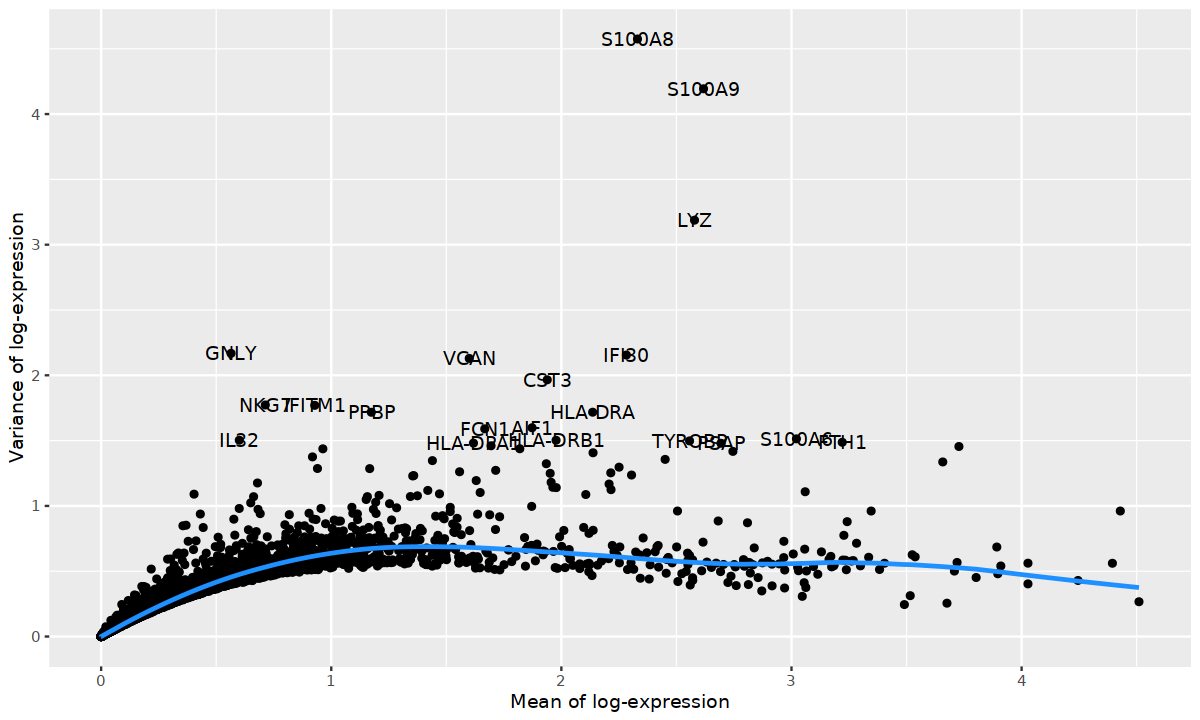

In [12]:
options(repr.plot.width = 10, repr.plot.height = 6, warn=-1,verbose = FALSE)
gene_var <- modelGeneVar(sce)

tops <- gene_var %>% 
    as.data.frame() %>% 
    arrange(desc(total)) %>% 
    head(n=20)

gene_var %>% 
  as.data.frame() %>% 
  ggplot(aes(mean, total)) +
  geom_point() +
  geom_line(aes(y = tech), colour = "dodgerblue", size = 1) +
  labs(x = "Mean of log-expression", y = "Variance of log-expression")+
  geom_text(data=tops, aes(mean,total,label=rownames(tops)))

In [13]:
hvgs <- getTopHVGs(gene_var,fdr.threshold = 0.05)
length(hvgs)

[1] 921

In [14]:
# remove TCR genes
hvgs <- hvgs[!grepl("^TR[ABDG][VJC]", hvgs)]

In [15]:
seurat_obj <- seurat_obj %>%
  ScaleData(features=hvgs) %>% 
  RunPCA(features=hvgs)

Centering and scaling data matrix

PC_ 1 
Positive:  IFI30, AIF1, FTL, FCN1, LYZ, CTSS, PSAP, LST1, S100A6, PLXDC2 
	   S100A9, SERPINA1, CYBB, NAMPT, S100A11, CST3, MNDA, LYN, VCAN, HLA-DRA 
	   VIM, S100A8, TYROBP, SLC8A1, HLA-DRB1, CDKN1A, ARHGAP26, SAT1, ZEB2, HLA-DQB1 
Negative:  CD247, SKAP1, IFITM1, IL32, CD7, PRKCH, IL2RG, CD69, GZMA, ZAP70 
	   PRF1, SLC38A1, SYNE2, CTSW, CD96, CST7, GNLY, IL2RB, NKG7, ETS1 
	   SAMD3, GZMM, KLRB1, TENT5C, PYHIN1, STAT4, GZMB, KLRK1, LCK, PCED1B-AS1 
PC_ 2 
Positive:  LILRA4, CLEC4C, NIBAN3, JCHAIN, SERPINF1, RHEX, DERL3, AC023590.1, LINC01478, MZB1 
	   PTPRS, LINC01374, ITM2C, TCF4, SPIB, CUX2, TLR9, IGKC, COBLL1, PLD4 
	   TPM2, AC007381.1, RGS7, FAM160A1, LINC00996, IGHM, AFF3, SCT, STMN1, TCL1A 
Negative:  NEAT1, CCL5, ANXA1, NKG7, GNLY, PRF1, ARHGAP26, NFKBIA, S100A9, S100A8 
	   S100A4, GZMA, IFITM3, CST7, IL2RB, KLRD1, FCN1, KLRK1, SLC2A3, VCAN 
	   CTSW, CD247, S100A12, LYZ, S100A11, CCL4, MCTP2, FCAR, CD14, KLRC1 
PC_ 3 
Positive:  G

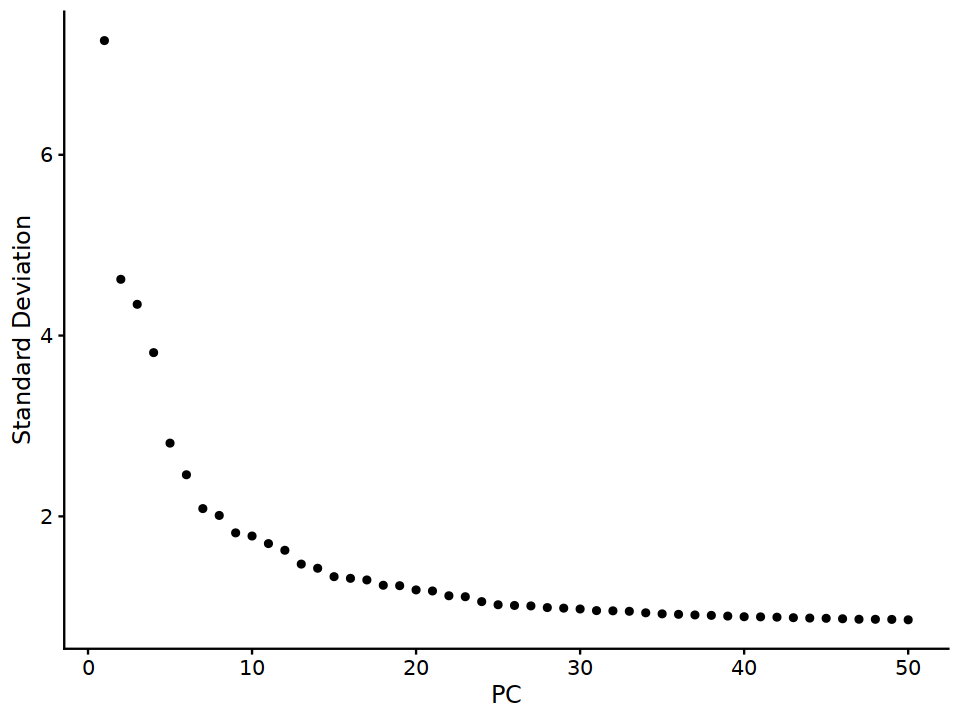

In [16]:
options(repr.plot.width = 8, repr.plot.height = 6)
ElbowPlot(seurat_obj, n=50)

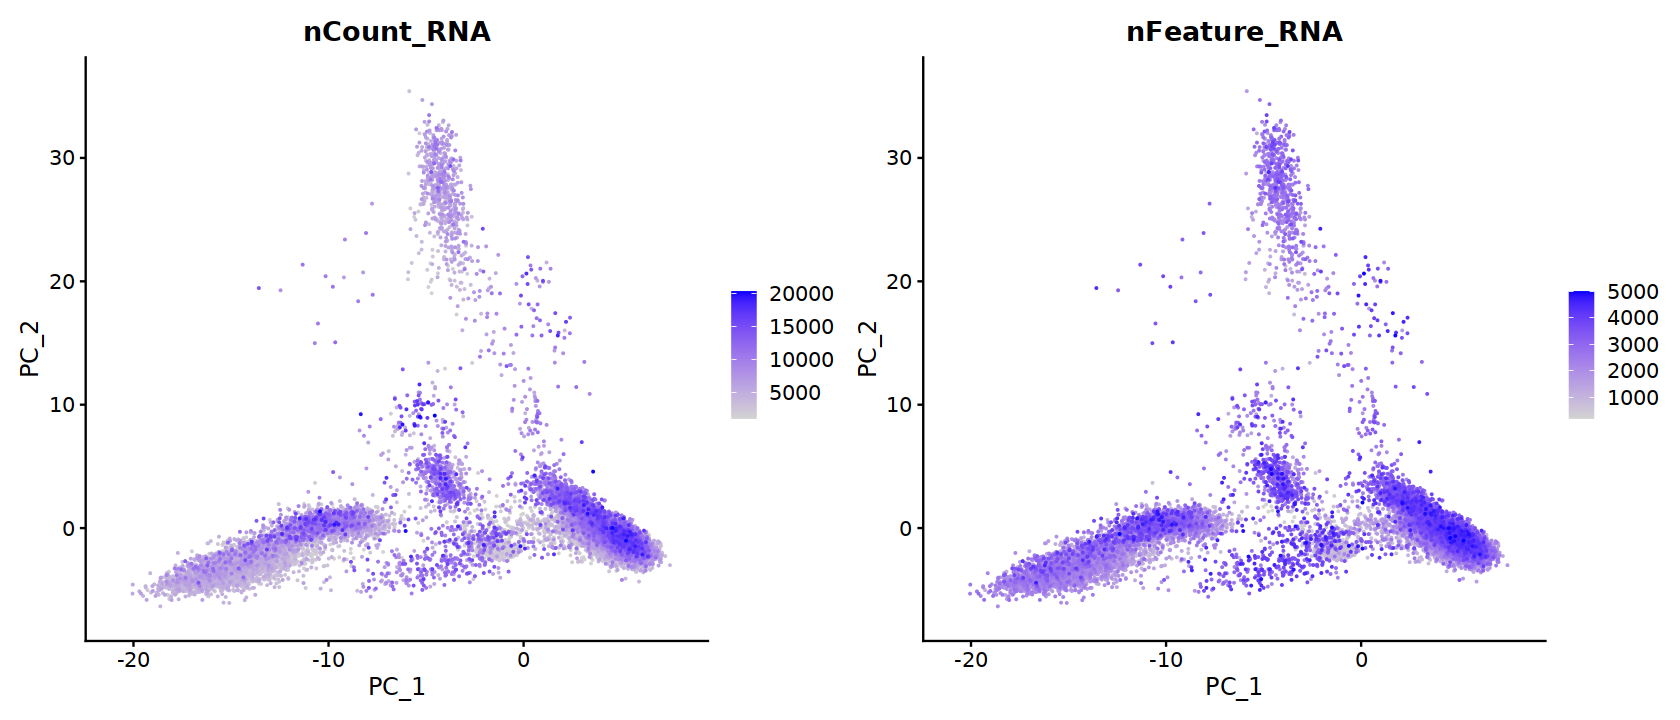

In [17]:
options(repr.plot.width = 14, repr.plot.height = 6)
FeaturePlot(object = seurat_obj, reduction = "pca",
        features = c("nCount_RNA","nFeature_RNA"), order=T)

In [18]:
comp=15

Integrate with harmony

In [19]:
# make a copy of the PCA reduction
seurat_obj@reductions$pca_filt <- seurat_obj@reductions$pca

# Filter to the desired number of components according to elbow
seurat_obj@reductions$pca_filt@cell.embeddings <- seurat_obj@reductions$pca_filt@cell.embeddings[, c(1:comp)]
seurat_obj@reductions$pca_filt@feature.loadings <- seurat_obj@reductions$pca_filt@feature.loadings[, c(1:comp)]

In [20]:
seurat_obj <- RunHarmony(
  object = seurat_obj,
  reduction = "pca_filt",
  group.by.vars = "sample_id",
  assay.use = "RNA",
  project.dim = FALSE,
  reduction.save = "harmony"
)

Transposing data matrix

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony converged after 5 iterations



In [21]:
seurat_obj <- RunUMAP(
  seurat_obj,
  dims = 1:comp,
  reduction = "harmony",
  reduction.name = "umap",
  reduction.key = "UMAP_"
)

17:02:31 UMAP embedding parameters a = 0.9922 b = 1.112

17:02:31 Read 26610 rows and found 15 numeric columns

17:02:31 Using Annoy for neighbor search, n_neighbors = 30

17:02:31 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:02:33 Writing NN index file to temp file /scratch_tmp/33937378/RtmpiC8PGI/file195717ec9db45

17:02:33 Searching Annoy index using 1 thread, search_k = 3000

17:02:42 Annoy recall = 100%

17:02:43 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

17:02:46 Initializing from normalized Laplacian + noise (using irlba)

17:02:47 Commencing optimization for 200 epochs, with 1115510 positive edges

17:03:16 Optimization finished



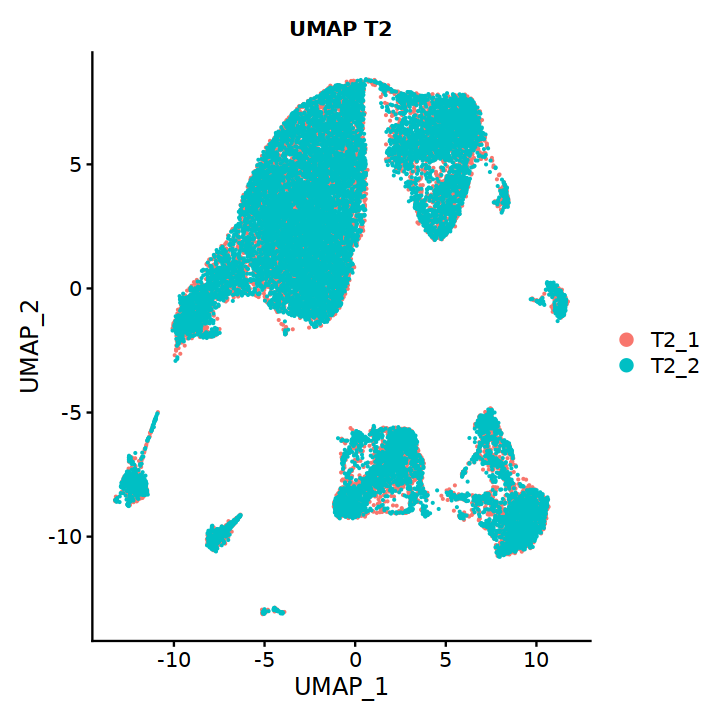

In [22]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(
  seurat_obj,
  reduction = "umap",
  group.by = "sample_id",
  pt.size = 0.1
) + ggtitle(glue('UMAP {timepoint}')) + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

## Remove doublets

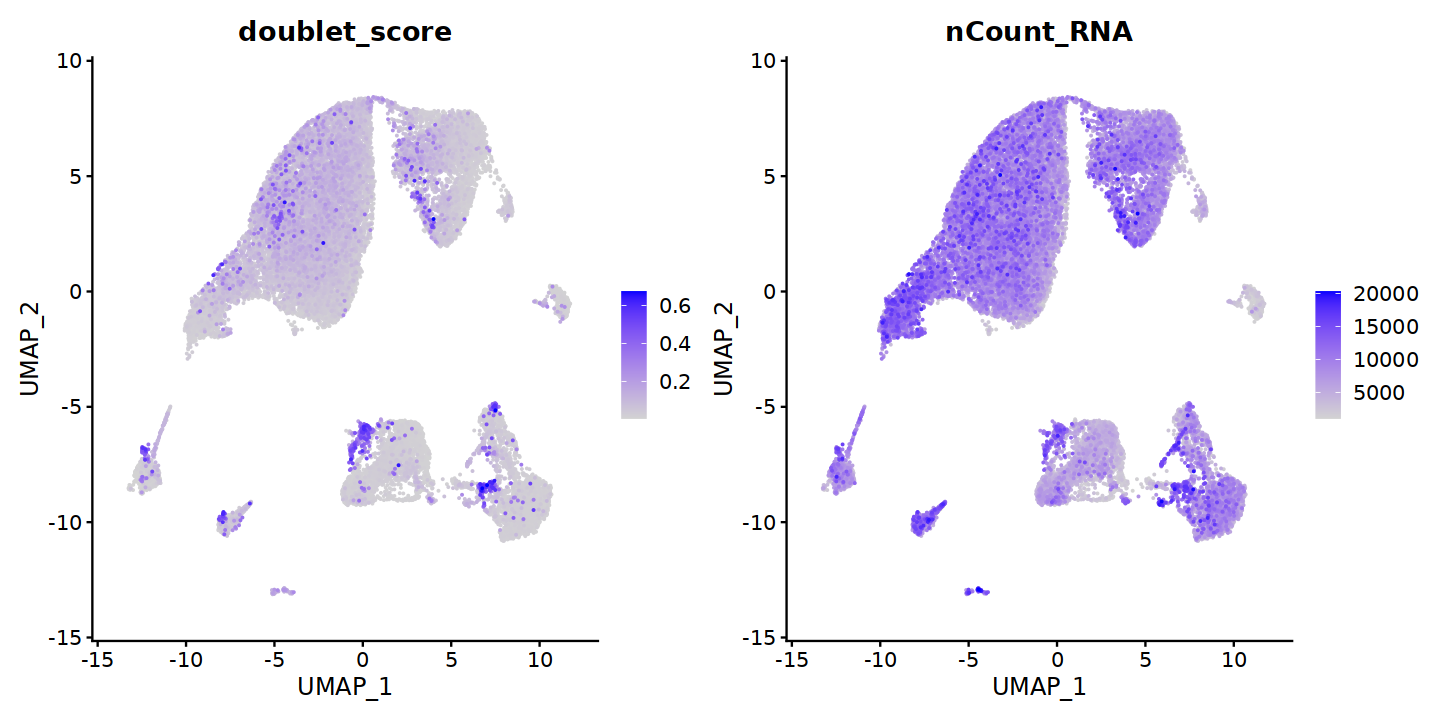

In [23]:
options(repr.plot.width = 12, repr.plot.height = 6, warn=-1,verbose = FALSE)
FeaturePlot(seurat_obj, reduction = "umap", 
            feature=c("doublet_score", "nCount_RNA"), order = TRUE)

### First clustering to localize doublets

In [24]:
# Find the K-nearest neighbors
seurat_obj <- FindNeighbors(seurat_obj, reduction = "harmony", dims = 1:comp)
# Find clusters at different resolutions
clusters_df <- cluster_diff_resolutions(
  seurat_obj = seurat_obj,
  min_resolution = 0.1,
  max_resolution = 1.0,
  step = 0.1
)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 26610
Number of edges: 896931

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9665
Number of communities: 10
Elapsed time: 7 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 26610
Number of edges: 896931

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9439
Number of communities: 11
Elapsed time: 6 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 26610
Number of edges: 896931

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9301
Number of communities: 15
Elapsed time: 6 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 26610
Number of edges: 896931

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9178
Number of communities: 15
Elapsed time: 6 seconds
Modularity O

In [25]:
list_plots <- lapply(unique(clusters_df$resolution), function(x) {
  p <- add_reso_results(seurat_obj, clusters_df, resolution=x)
  umap <- DimPlot(p, reduction = "umap", 
                  group.by=glue::glue("seurat_clusters")) +
    labs(title=glue::glue("Resolution {x}"))
  return(umap)
})

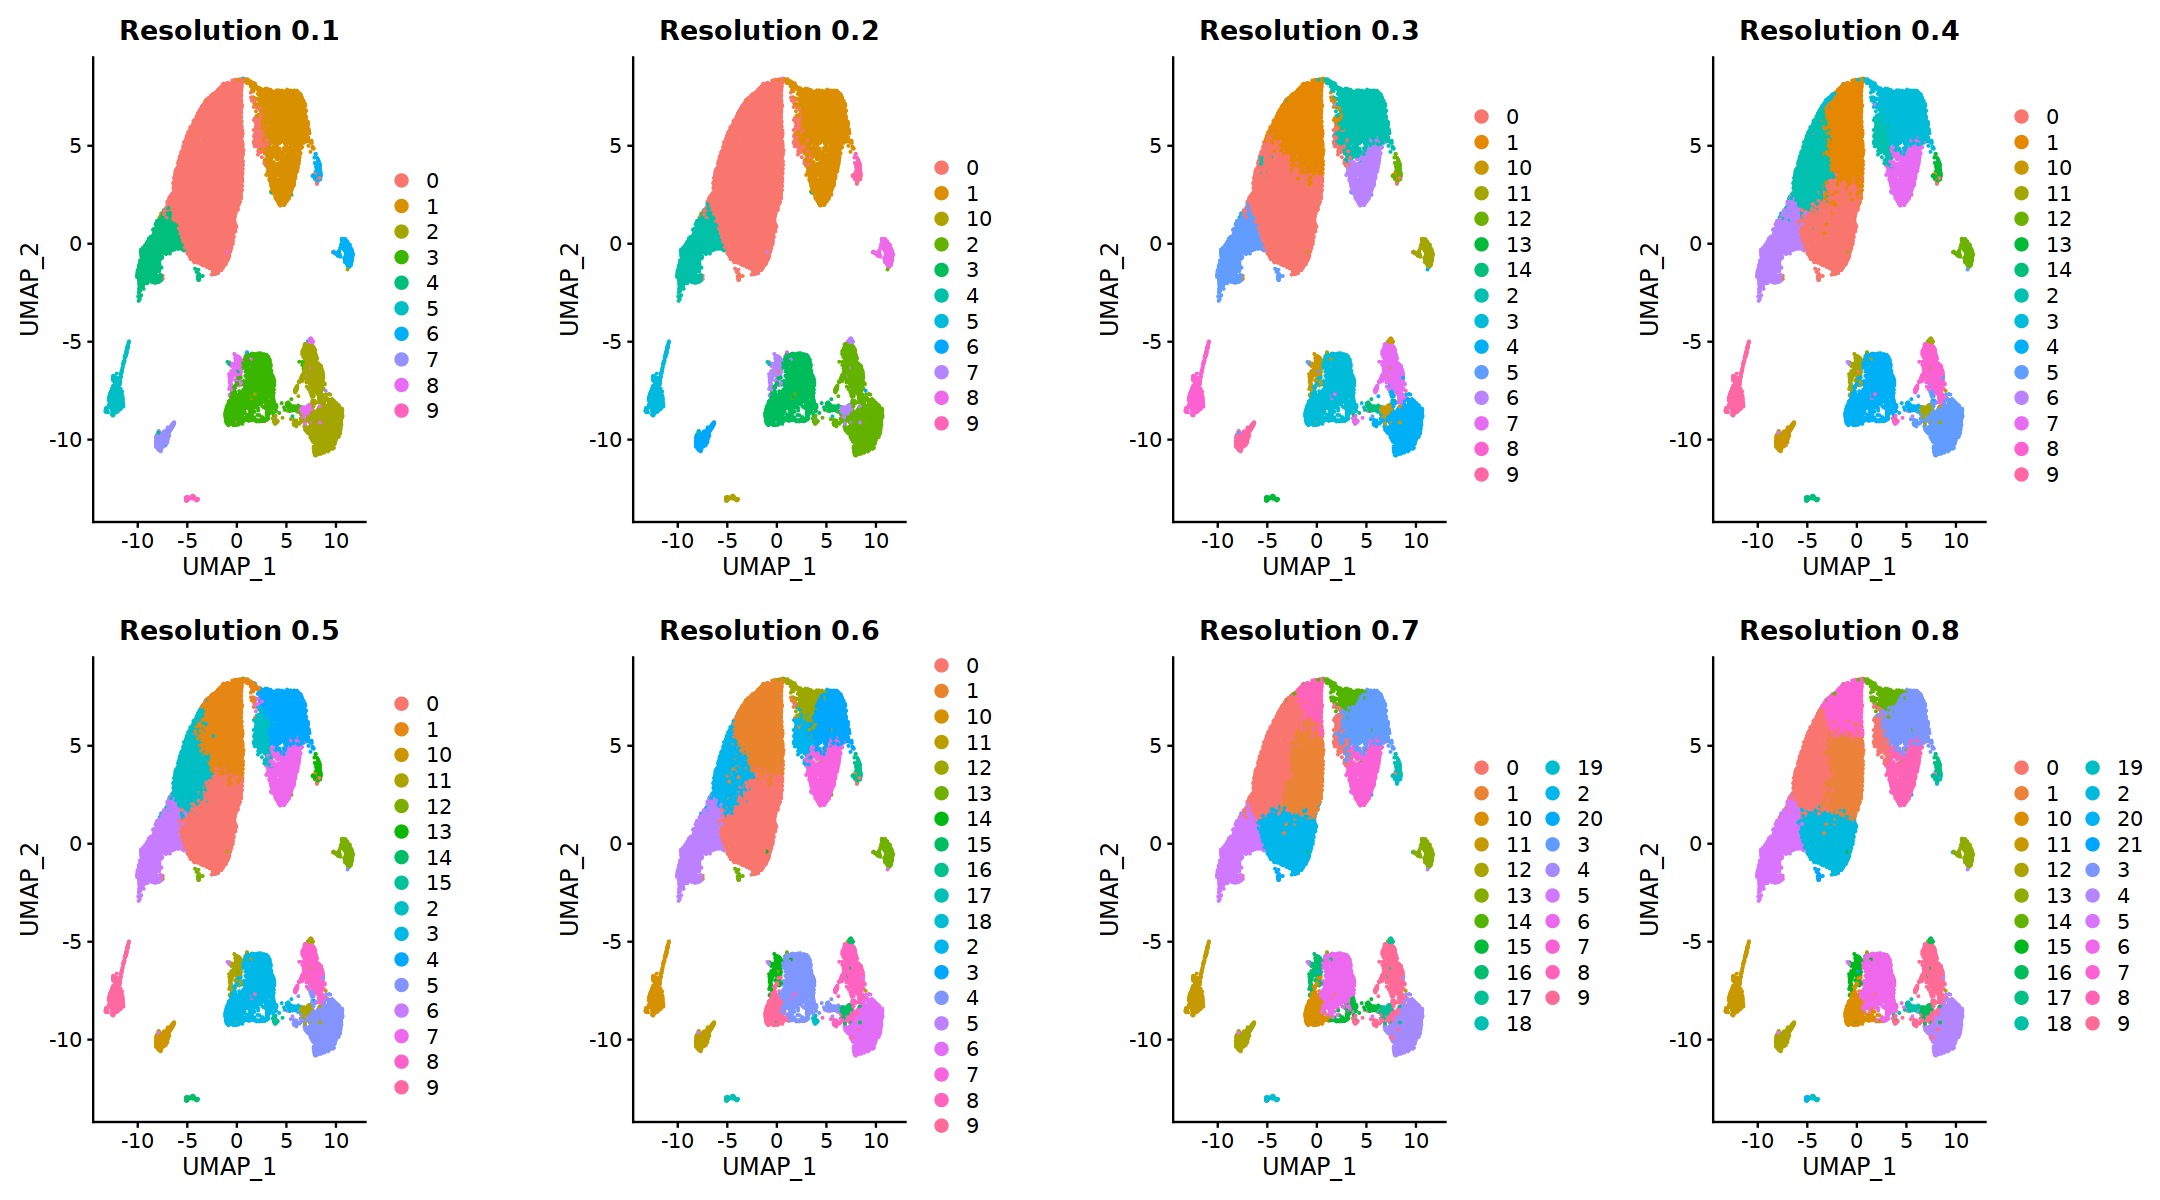

In [26]:
options(repr.plot.width = 18, repr.plot.height = 10, warn=-1,verbose = FALSE)
cp <- cowplot::plot_grid(plotlist = list_plots,
                   align = "hv",
                   axis = "trbl",
                   ncol=4,
                   nrow=2)
cp

In [27]:
reso=0.3

In [28]:
seurat_obj <- FindClusters(seurat_obj, resolution = reso)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 26610
Number of edges: 896931

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9301
Number of communities: 15
Elapsed time: 6 seconds


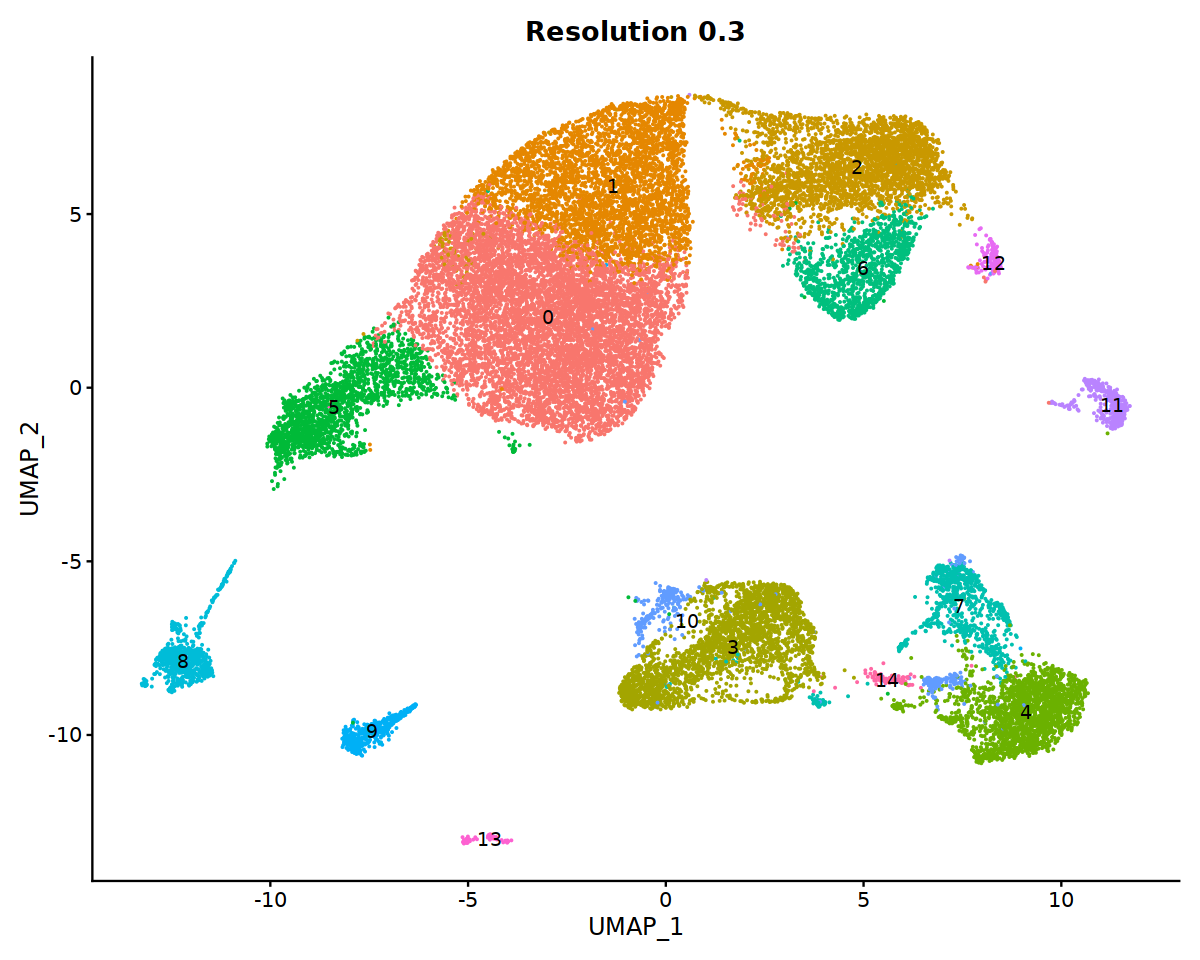

In [29]:
options(repr.plot.width = 10, repr.plot.height = 8, warn=-1,verbose = FALSE)
DimPlot(seurat_obj, reduction = "umap", label = T)+ NoLegend() +
  labs(title=glue("Resolution {reso}")) + theme(plot.title = element_text(hjust = 0.5))

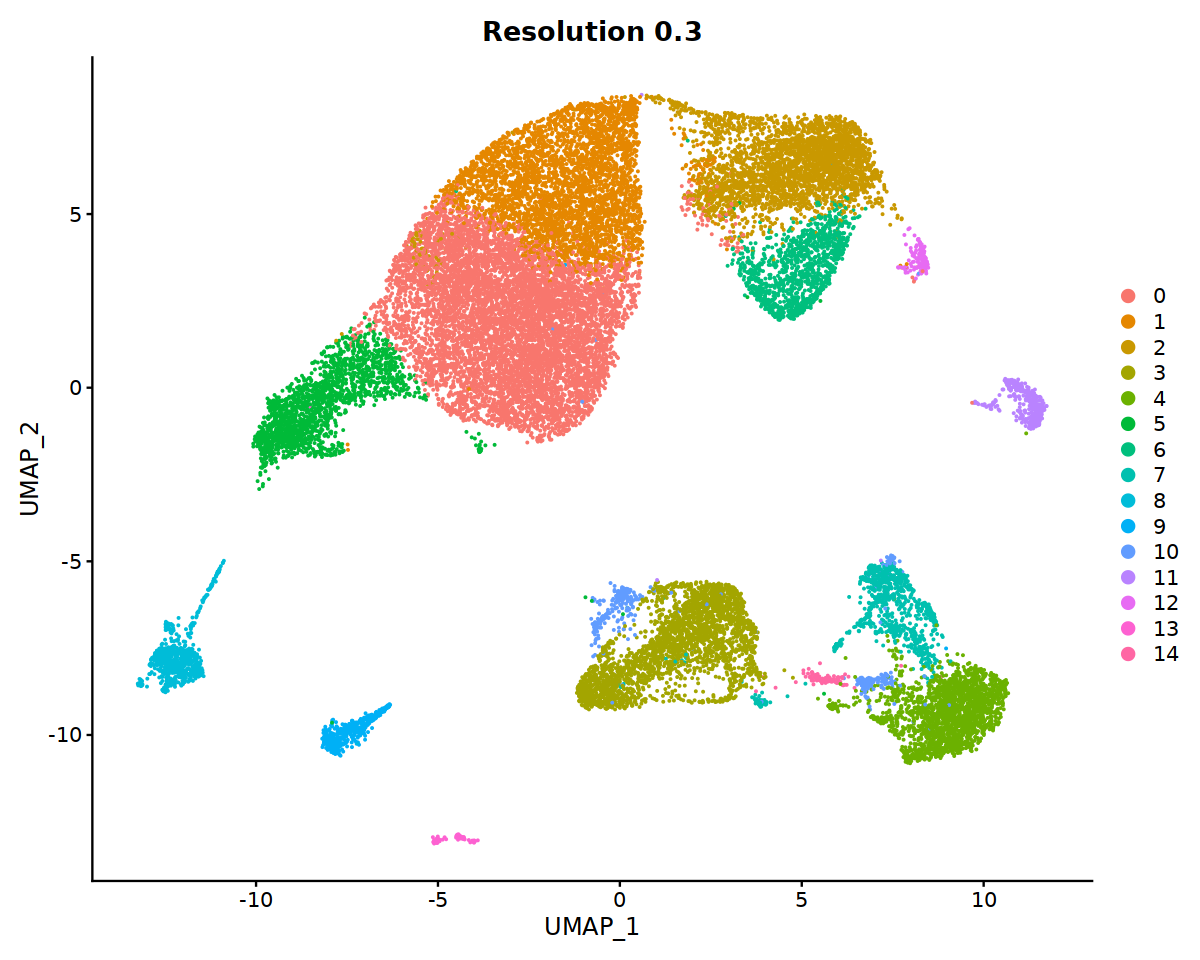

In [30]:
options(repr.plot.width = 10, repr.plot.height = 8, warn=-1,verbose = FALSE)
DimPlot(seurat_obj, reduction = "umap", label = F) +
  labs(title=glue("Resolution {reso}")) + theme(plot.title = element_text(hjust = 0.5))

### Obtain markers to corroborate doublets by gene expression

In [31]:
rna.markers <- FindAllMarkers(seurat_obj, min.pct = 0.1, logfc.threshold = 0.1, 
                              random.seed=0, max.cells.per.ident=1000,
                              only.pos=TRUE)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14



In [32]:
write_csv(rna.markers, here(glue("{clust}/{robj_dir}/3.2-first_clustering_{timepoint}.csv")))

In [33]:
markers <- c("PTPRC","nCount_RNA", "nFeature_RNA",
             "doublet_score",
             "CD3E", "CD3D","NCAM1","KLRD1","FCGR3A",
             "CD14", "CD68", 
             "S100A8", "SPP1", "CD163", "MSR1",
             "HBB")

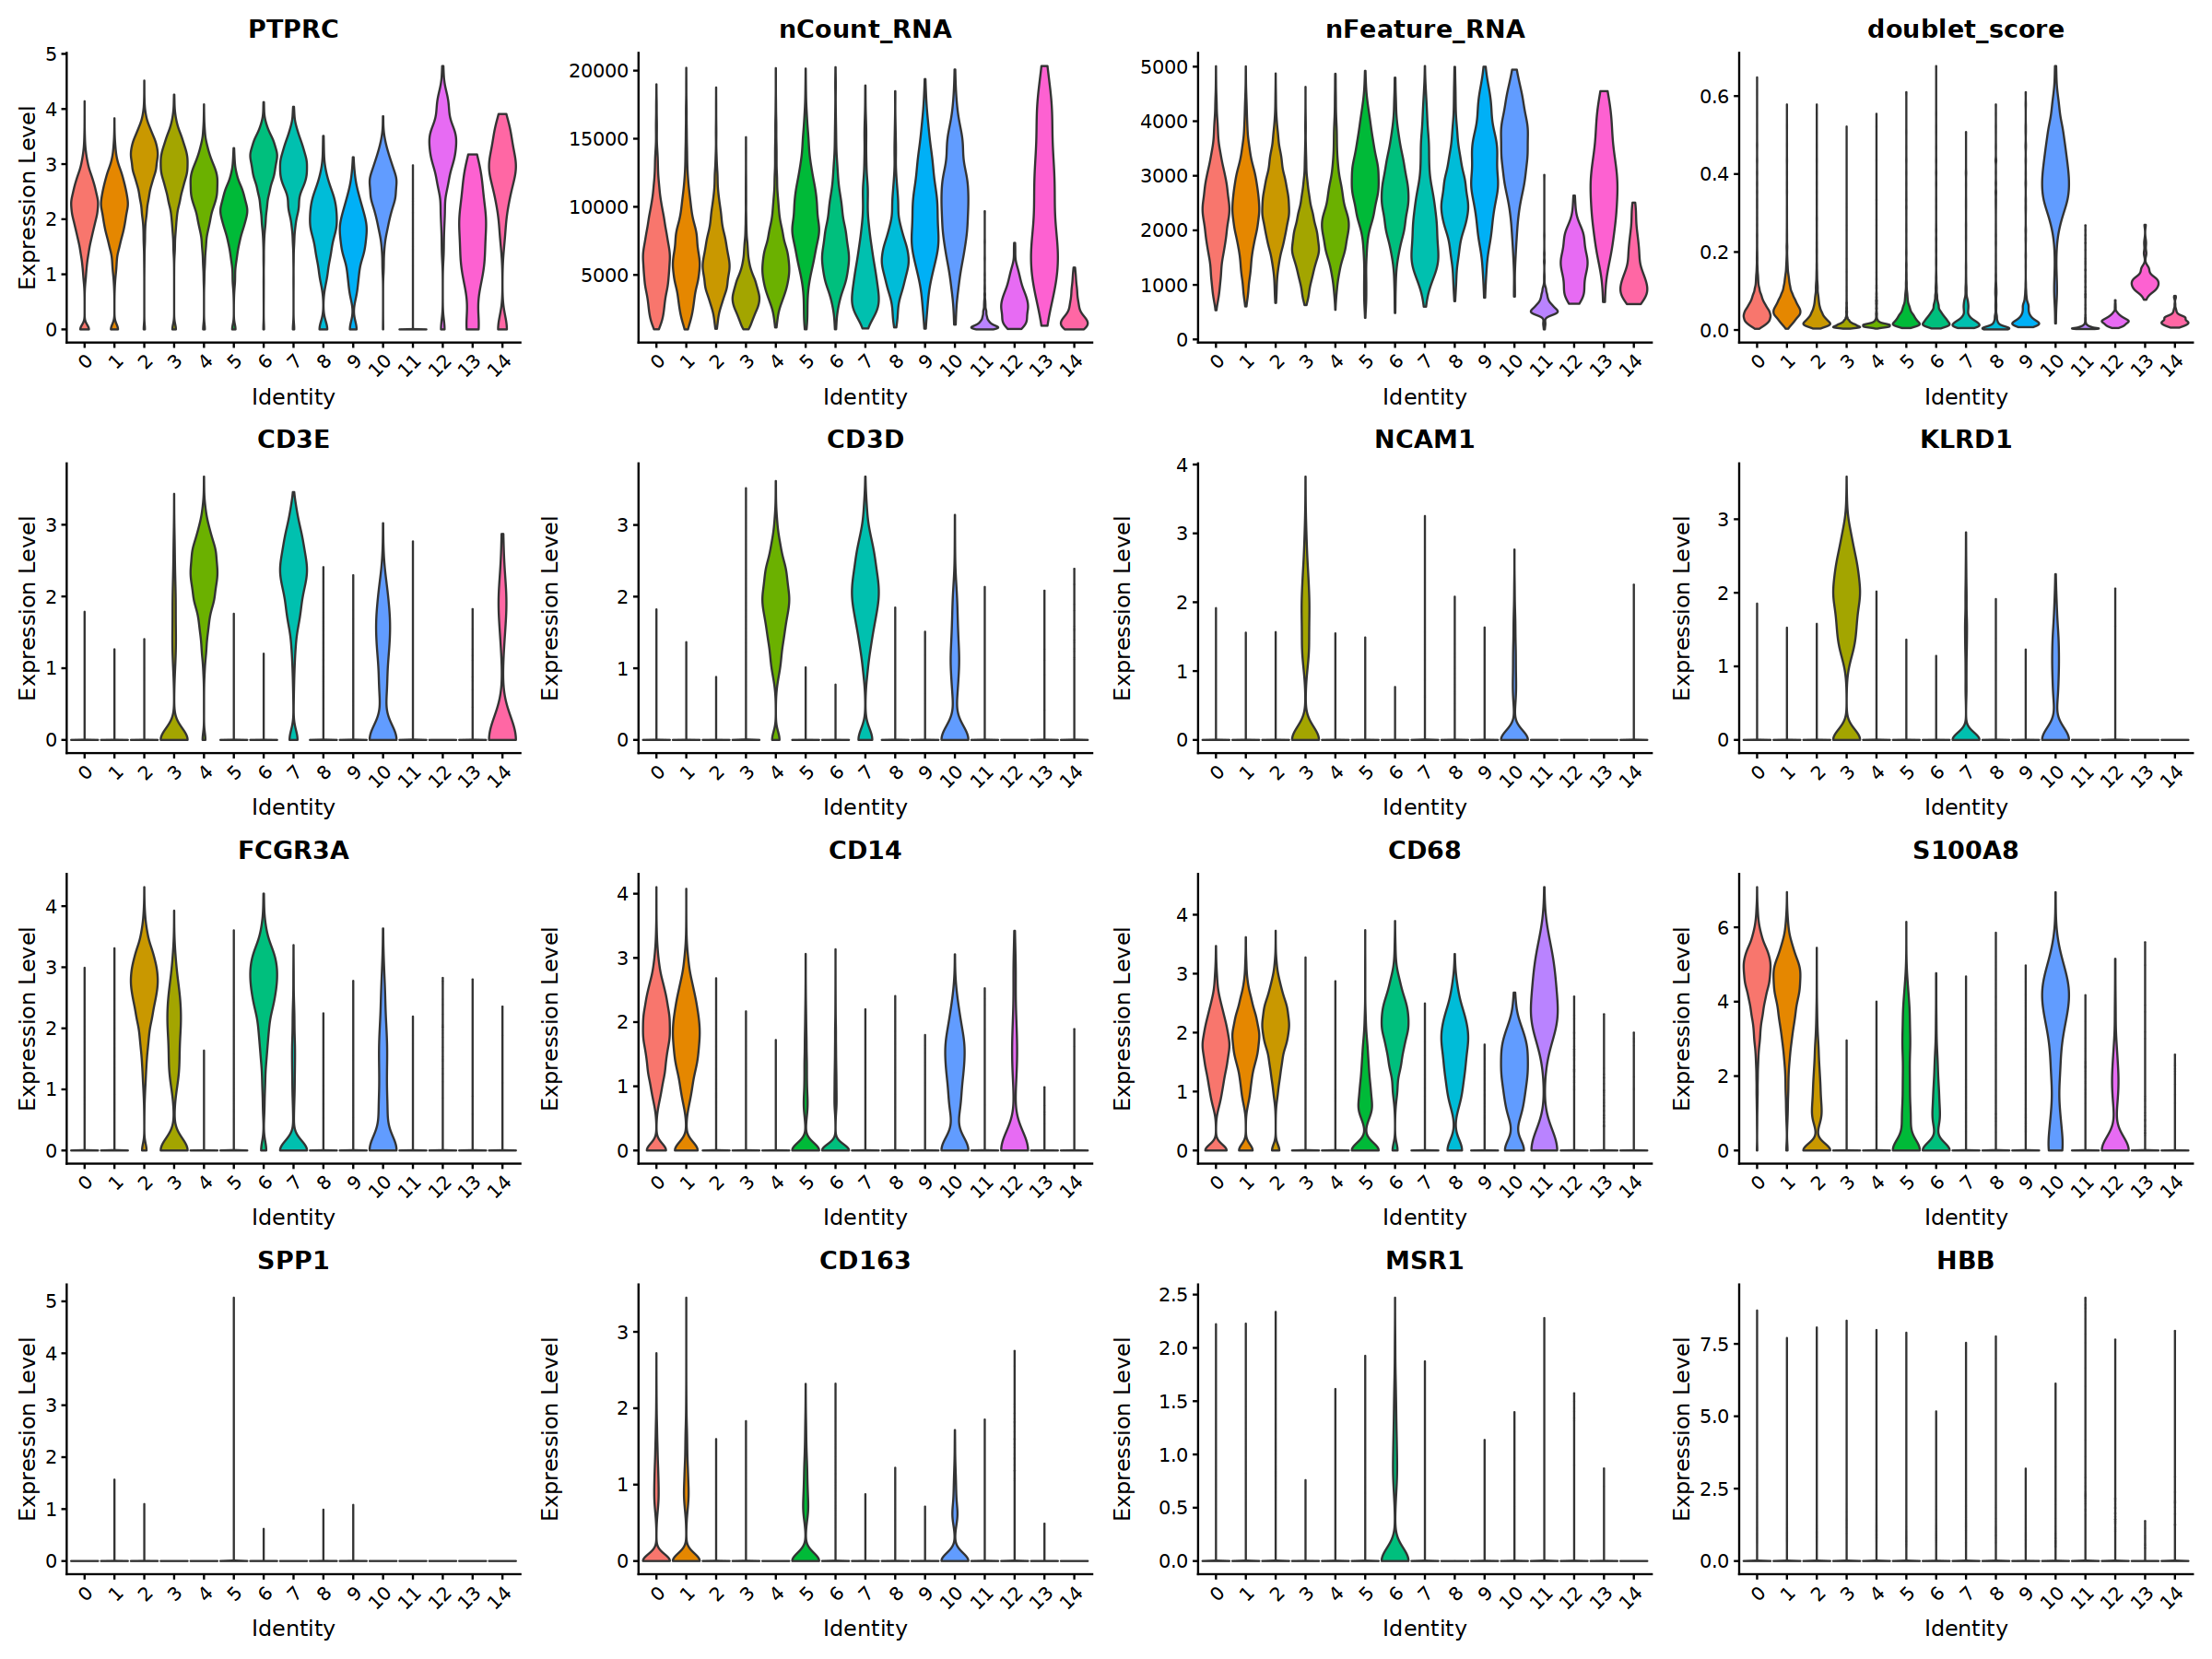

In [34]:
options(repr.plot.width = 20, repr.plot.height = 15, warn=-1,verbose = FALSE)
VlnPlot(seurat_obj, feature=markers, ncol=4, pt.size = 0)

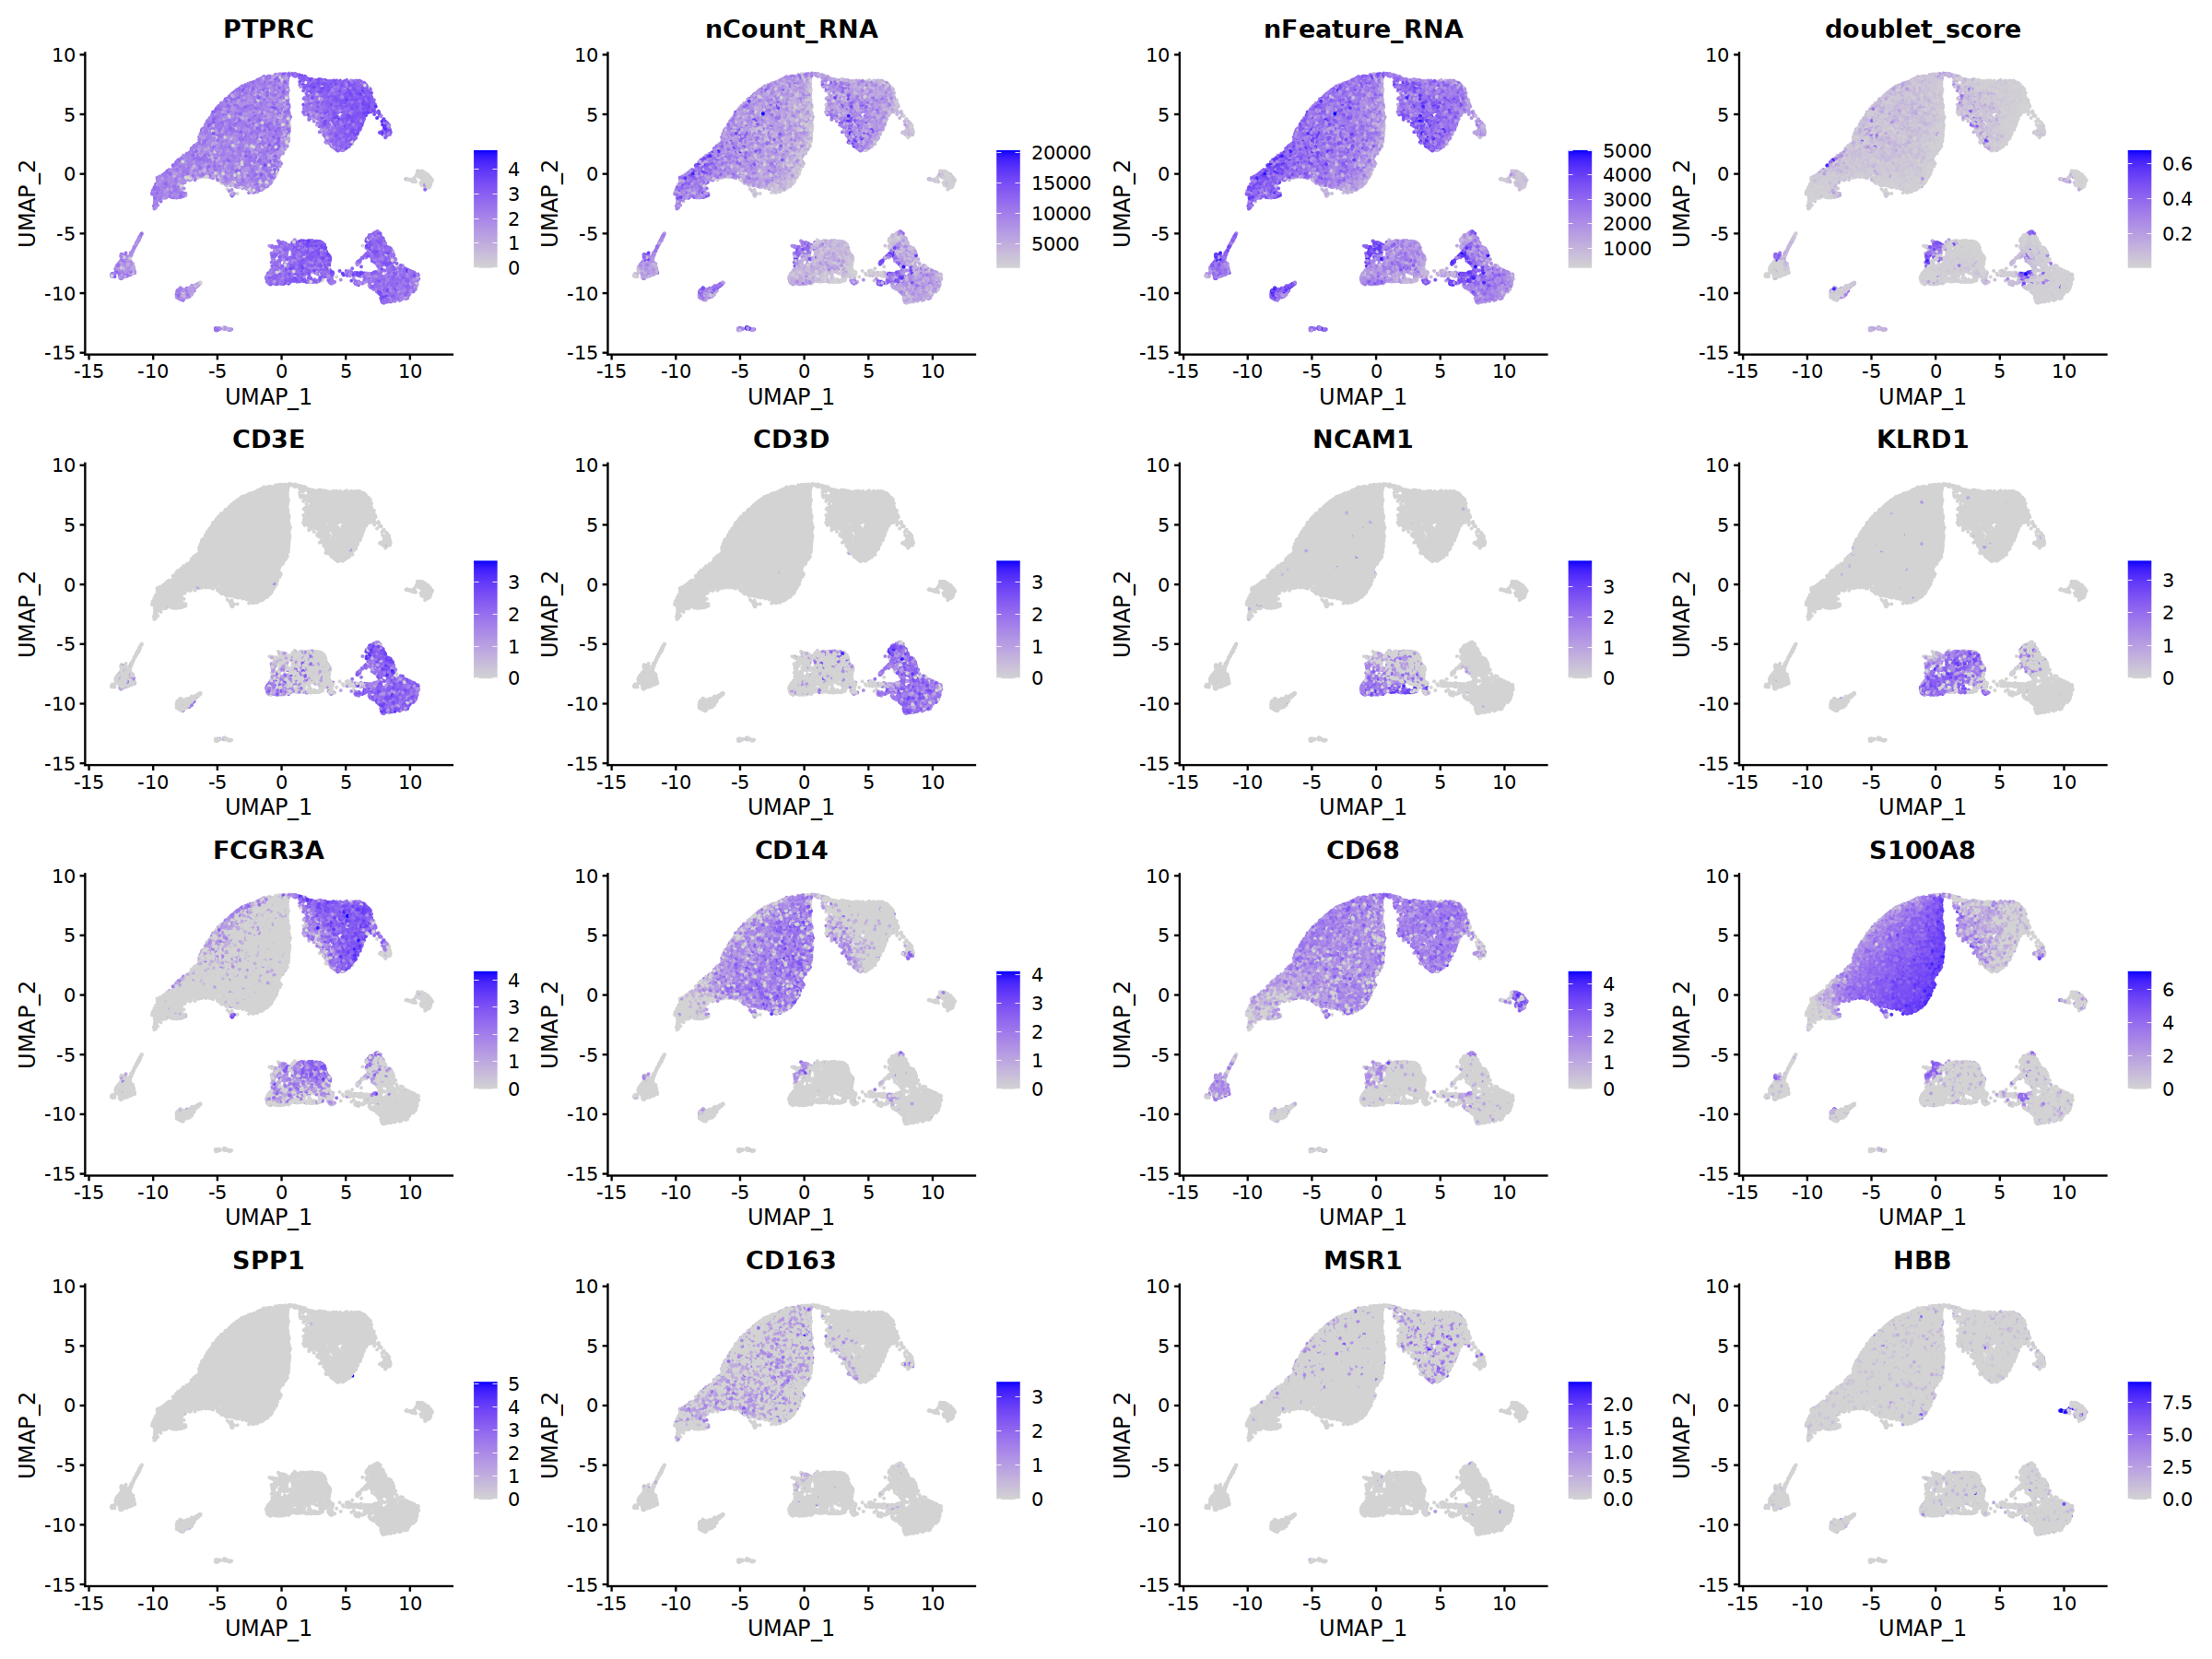

In [35]:
options(repr.plot.width = 20, repr.plot.height = 15, warn=-1,verbose = FALSE)
FeaturePlot(seurat_obj, ncol=4,
            feature=markers)

low quality cells

In [36]:
c <- 11
rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head(n=15)

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene  
HBB      9.982856e-07 6.471469   0.208 0.132  2.913397e-02 11      HBB   
PPBP1   3.546390e-178 5.777565   0.980 0.561 1.034979e-173 11      PPBP  
PF41    2.000138e-182 5.218382   0.965 0.404 5.837203e-178 11      PF4   
TUBB11  6.332820e-194 5.182401   0.975 0.335 1.848170e-189 11      TUBB1 
GP91    4.292925e-213 4.987832   0.967 0.190 1.252847e-208 11      GP9   
GNG111  3.680025e-194 4.865164   0.972 0.328 1.073978e-189 11      GNG11 
MPIG6B1 6.582073e-200 4.659869   0.947 0.211 1.920912e-195 11      MPIG6B
CAVIN21 1.783608e-195 4.631357   0.975 0.338 5.205282e-191 11      CAVIN2
MYL91   7.197827e-176 4.572210   0.897 0.239 2.100614e-171 11      MYL9  
ITGA2B1 5.487847e-201 4.510406   0.935 0.191 1.601573e-196 11      ITGA2B
ACRBP1  1.865417e-175 4.477077   0.887 0.208 5.444032e-171 11      ACRBP 
TUBA4A1 2.030525e-179 4.469561   0.945 0.350 5.925883e-175 11      TUBA4A
RGS181  1.983746e-179 4.431425   0.937 0.343 5.789363e-175 11      RGS18 
TMEM401 8.206099e-213 4.287094   0.880 0.083 2.394868e-208 11      TMEM40
CLU1    8.390330e-170 4.269285   0.915 0.279 2.448634e-165 11      CLU

doublets

In [37]:
c <- 10
rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head(n=15)

p_val        avg_log2FC pct.1 pct.2 p_val_adj    cluster gene   
GNLY2    6.020526e-52 0.8703340  0.579 0.138 1.757030e-47 10      GNLY   
SKAP13   1.045539e-82 0.7587356  0.869 0.206 3.051300e-78 10      SKAP1  
IFITM13  6.845921e-61 0.7455174  0.939 0.382 1.997914e-56 10      IFITM1 
CD2473   1.554885e-81 0.7191359  0.886 0.205 4.537775e-77 10      CD247  
LTB3     1.330313e-27 0.7053190  0.505 0.208 3.882386e-23 10      LTB    
NKG72    4.816215e-40 0.7013246  0.708 0.311 1.405564e-35 10      NKG7   
IL323    1.011243e-65 0.6491906  0.804 0.200 2.951211e-61 10      IL32   
PRKCH3   7.841935e-64 0.6442384  0.893 0.298 2.288590e-59 10      PRKCH  
CD693    8.102651e-57 0.6383219  0.881 0.348 2.364678e-52 10      CD69   
PRF12    3.516385e-57 0.6365999  0.626 0.139 1.026222e-52 10      PRF1   
RNF1254  7.731027e-46 0.6044223  0.818 0.309 2.256223e-41 10      RNF125 
TNFAIP33 5.579391e-28 0.5986219  0.893 0.540 1.628289e-23 10      TNFAIP3
SYNE23   6.538484e-69 0.5964836  0.785 0.189 1.908191e-64 10      SYNE2  
IL2RB2   1.084710e-51 0.5946942  0.565 0.136 3.165618e-47 10      IL2RB  
CCL42    3.446540e-27 0.5853414  0.360 0.098 1.005838e-22 10      CCL4

### Remove cells

In [38]:
seurat_obj <- subset(seurat_obj, idents=c(10,11), invert=TRUE)

In [39]:
print(table(rowSums(as.matrix(seurat_obj[['RNA']]@counts)) == 0))
  
keep_genes <- data.frame(rowSums(as.matrix(seurat_obj[['RNA']]@counts)) != 0)
colnames(keep_genes) <- "logical"
keep_genes <- subset(keep_genes, logical==TRUE)
seurat_obj[['RNA']]@counts <- seurat_obj[['RNA']]@counts[rownames(keep_genes), ]
seurat_obj[['RNA']]@data <- seurat_obj[['RNA']]@data[rownames(keep_genes), ]
seurat_obj


FALSE  TRUE 
29108    76 


An object of class Seurat 
29108 features across 25783 samples within 1 assay 
Active assay: RNA (29108 features, 0 variable features)
 4 dimensional reductions calculated: pca, pca_filt, harmony, umap

## Re-do embedding and clustering

In [40]:
seurat_obj <- NormalizeData(
  seurat_obj,
  normalization.method = "LogNormalize",
  scale.factor = 1e4
)

In [41]:
sce <- as.SingleCellExperiment(seurat_obj)
sce

class: SingleCellExperiment 
dim: 29108 25783 
metadata(0):
assays(2): counts logcounts
rownames(29108): AL627309.1 AL627309.5 ... AC010086.3 TTTY17C
rowData names(0):
colnames(25783): T2_1_AAACCTGAGCGTTGCC-1 T2_1_AAACCTGAGCTAGGCA-1 ...
  T2_2_TTTGTCATCTCGTTTA-1 T2_2_TTTGTCATCTTATCTG-1
colData names(18): orig.ident nCount_RNA ... seurat_clusters ident
reducedDimNames(4): PCA PCA_FILT HARMONY UMAP
mainExpName: RNA
altExpNames(0):

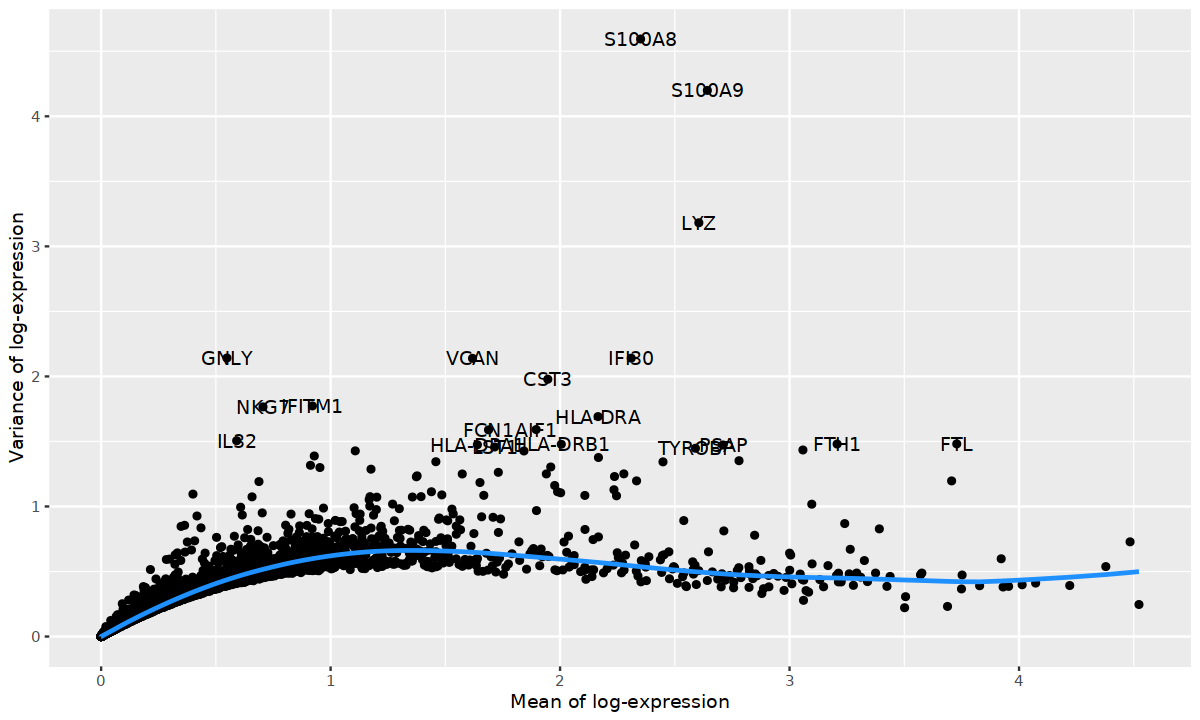

In [42]:
options(repr.plot.width = 10, repr.plot.height = 6, warn=-1,verbose = FALSE)
gene_var <- modelGeneVar(sce)

tops <- gene_var %>% 
    as.data.frame() %>% 
    arrange(desc(total)) %>% 
    head(n=20)

gene_var %>% 
  as.data.frame() %>% 
  ggplot(aes(mean, total)) +
  geom_point() +
  geom_line(aes(y = tech), colour = "dodgerblue", size = 1) +
  labs(x = "Mean of log-expression", y = "Variance of log-expression")+
  geom_text(data=tops, aes(mean,total,label=rownames(tops)))

In [43]:
hvgs <- getTopHVGs(gene_var,fdr.threshold = 0.05)
length(hvgs)

[1] 876

In [44]:
hvgs <- hvgs[!grepl("^TR[ABDG][VJC]", hvgs)]
length(hvgs)

[1] 777

In [45]:
seurat_obj <- seurat_obj %>%
  ScaleData(features=hvgs) %>% 
  RunPCA(features=hvgs)

Centering and scaling data matrix

PC_ 1 
Positive:  IFI30, AIF1, FCN1, LYZ, FTL, CTSS, PSAP, LST1, S100A6, PLXDC2 
	   SERPINA1, CYBB, NAMPT, S100A9, S100A11, SPI1, CST3, LYN, MNDA, HLA-DRA 
	   TYROBP, VIM, VCAN, SLC8A1, HLA-DRB1, S100A8, ZEB2, SAT1, CDKN1A, ARHGAP26 
Negative:  CD247, SKAP1, IL32, IFITM1, CD7, PRKCH, IL2RG, CD69, ZAP70, GZMA 
	   SYNE2, SLC38A1, CD96, PRF1, CTSW, ETS1, CST7, GNLY, IL2RB, TENT5C 
	   SAMD3, NKG7, GZMM, KLRB1, PYHIN1, LCK, ABLIM1, PCED1B-AS1, STAT4, RHOH 
PC_ 2 
Positive:  LILRA4, CLEC4C, NIBAN3, JCHAIN, SERPINF1, DERL3, RHEX, AC023590.1, LINC01478, MZB1 
	   PTPRS, LINC01374, ITM2C, TCF4, SPIB, CUX2, TLR9, COBLL1, IGKC, PLD4 
	   TPM2, SMPD3, RGS7, AC007381.1, FAM160A1, LINC00996, MYBL2, IGHM, AFF3, PLXNA4 
Negative:  NEAT1, ANXA1, S100A4, NFKBIA, IFITM3, ARHGAP26, CCL5, NKG7, PRF1, GNLY 
	   S100A9, GZMA, S100A8, FCN1, S100A11, CST7, IL2RB, KLRD1, JUNB, SLC2A3 
	   FOS, KLRK1, VCAN, NAMPT, S100A10, LYZ, SERPINA1, ZFP36, CD247, CTSW 
PC_ 3 
Positive:

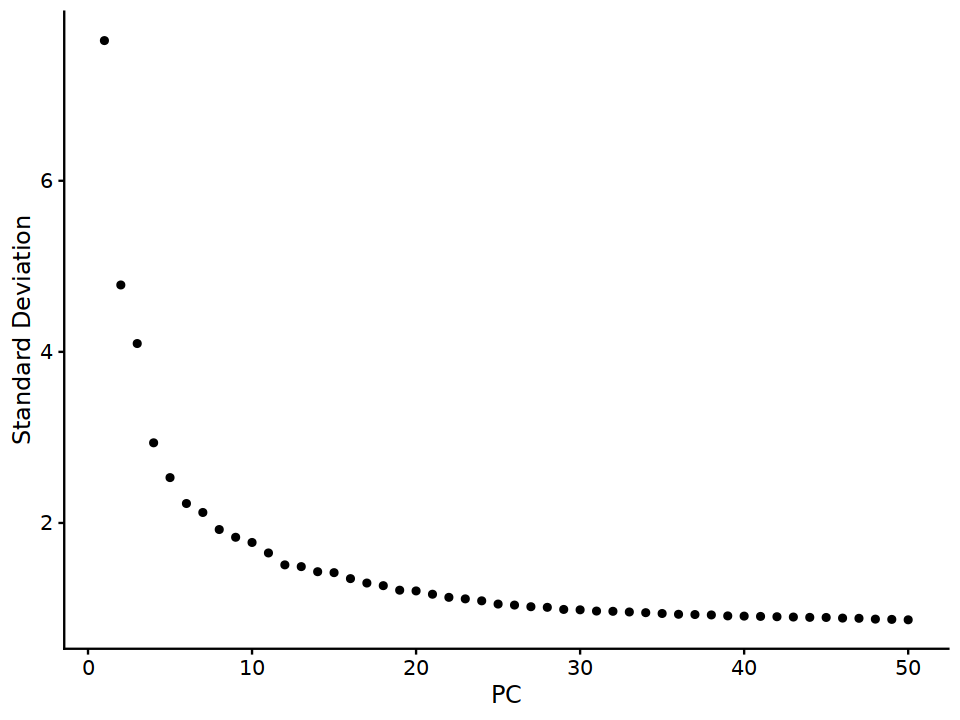

In [46]:
options(repr.plot.width = 8, repr.plot.height = 6)
ElbowPlot(seurat_obj, n=50)

In [47]:
comp=20

In [48]:
seurat_obj <- RunUMAP(
  seurat_obj,
  dims = 1:comp,
  reduction = "pca",
  reduction.name = "umap",
  reduction.key = "UMAP_"
)

17:09:14 UMAP embedding parameters a = 0.9922 b = 1.112

17:09:14 Read 25783 rows and found 20 numeric columns

17:09:14 Using Annoy for neighbor search, n_neighbors = 30

17:09:14 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:09:16 Writing NN index file to temp file /scratch_tmp/33937378/RtmpiC8PGI/file195716ca478fa

17:09:16 Searching Annoy index using 1 thread, search_k = 3000

17:09:24 Annoy recall = 100%

17:09:25 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

17:09:27 Initializing from normalized Laplacian + noise (using irlba)

17:09:28 Commencing optimization for 200 epochs, with 1076164 positive edges

17:09:57 Optimization finished



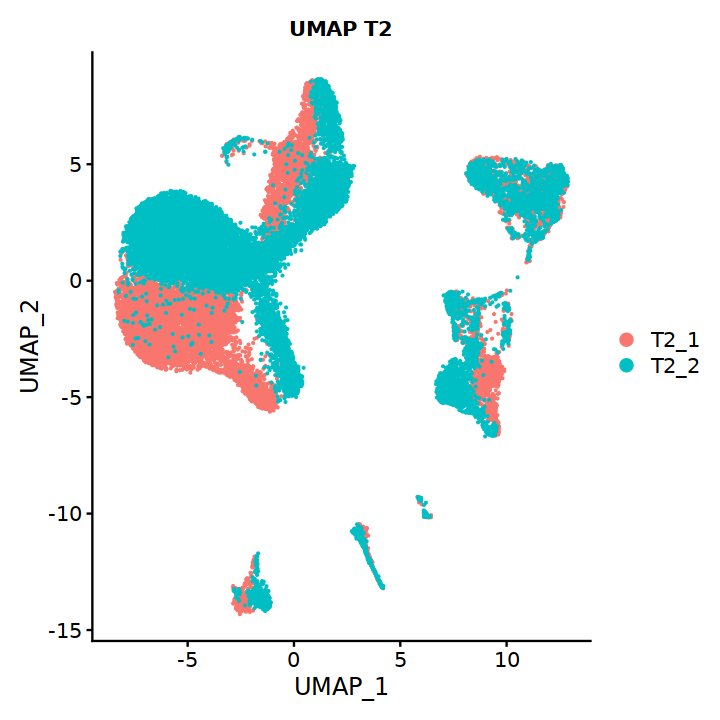

In [49]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(
  seurat_obj,
  reduction = "umap",
  group.by = "sample_id",
  pt.size = 0.1
) + ggtitle(glue('UMAP {timepoint}')) + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

In [50]:
# make a copy of the PCA reduction
seurat_obj@reductions$pca_filt <- seurat_obj@reductions$pca

# Filter to the desired number of components according to elbow
seurat_obj@reductions$pca_filt@cell.embeddings <- seurat_obj@reductions$pca_filt@cell.embeddings[, c(1:comp)]
seurat_obj@reductions$pca_filt@feature.loadings <- seurat_obj@reductions$pca_filt@feature.loadings[, c(1:comp)]

seurat_obj <- RunHarmony(
  object = seurat_obj,
  reduction = "pca_filt",
  group.by.vars = "sample_id",
  assay.use = "RNA",
  project.dim = FALSE,
  reduction.save = "harmony"
)

Transposing data matrix

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony converged after 4 iterations



In [51]:
seurat_obj <- RunUMAP(
  seurat_obj,
  dims = 1:comp,
  reduction = "harmony",
  reduction.name = "umap",
  reduction.key = "UMAP_"
)

17:10:19 UMAP embedding parameters a = 0.9922 b = 1.112

17:10:19 Read 25783 rows and found 20 numeric columns

17:10:19 Using Annoy for neighbor search, n_neighbors = 30

17:10:19 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:10:21 Writing NN index file to temp file /scratch_tmp/33937378/RtmpiC8PGI/file19571386f894

17:10:22 Searching Annoy index using 1 thread, search_k = 3000

17:10:30 Annoy recall = 100%

17:10:31 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

17:10:33 Initializing from normalized Laplacian + noise (using irlba)

17:10:34 Commencing optimization for 200 epochs, with 1092680 positive edges

17:11:02 Optimization finished



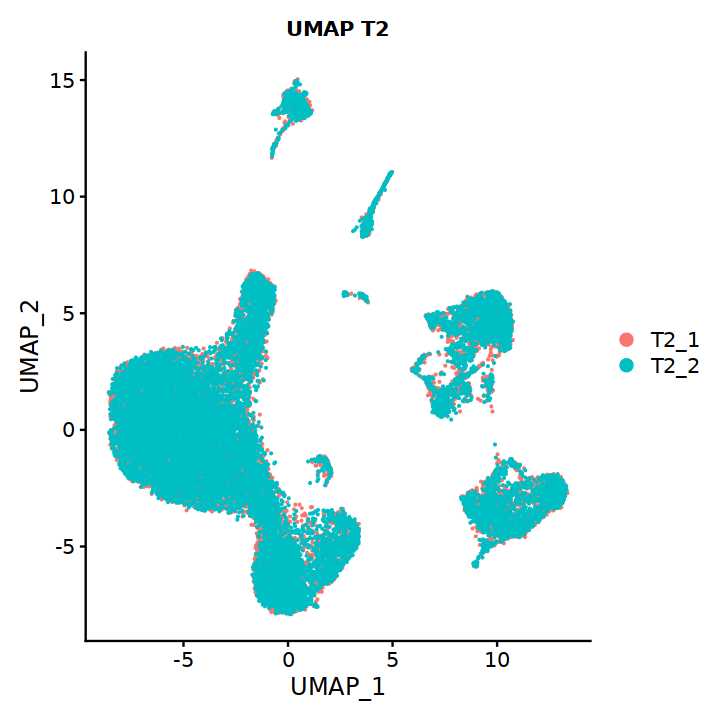

In [52]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(
  seurat_obj,
  reduction = "umap",
  group.by = "sample_id",
  pt.size = 0.1
) + ggtitle(glue('UMAP {timepoint}')) + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

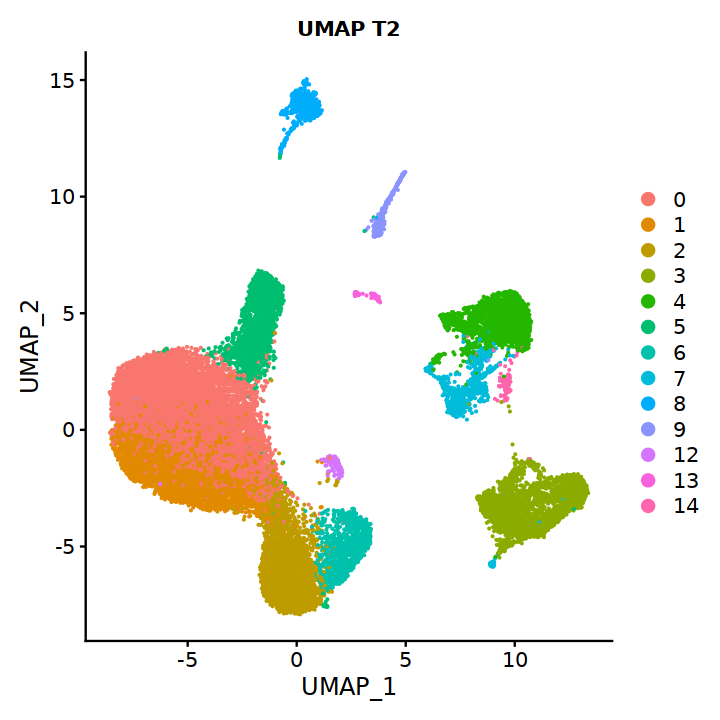

In [53]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(
  seurat_obj,
  reduction = "umap",
  pt.size = 0.1
) + ggtitle(glue('UMAP {timepoint}')) + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

### Clustering 

In [54]:
seurat_obj <- FindNeighbors(seurat_obj, reduction = "harmony", dims = 1:comp)

Computing nearest neighbor graph

Computing SNN



In [55]:
reso = 0.2

In [56]:
seurat_obj <- FindClusters(seurat_obj, resolution = reso)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 25783
Number of edges: 879629

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9421
Number of communities: 12
Elapsed time: 7 seconds


1 singletons identified. 11 final clusters.



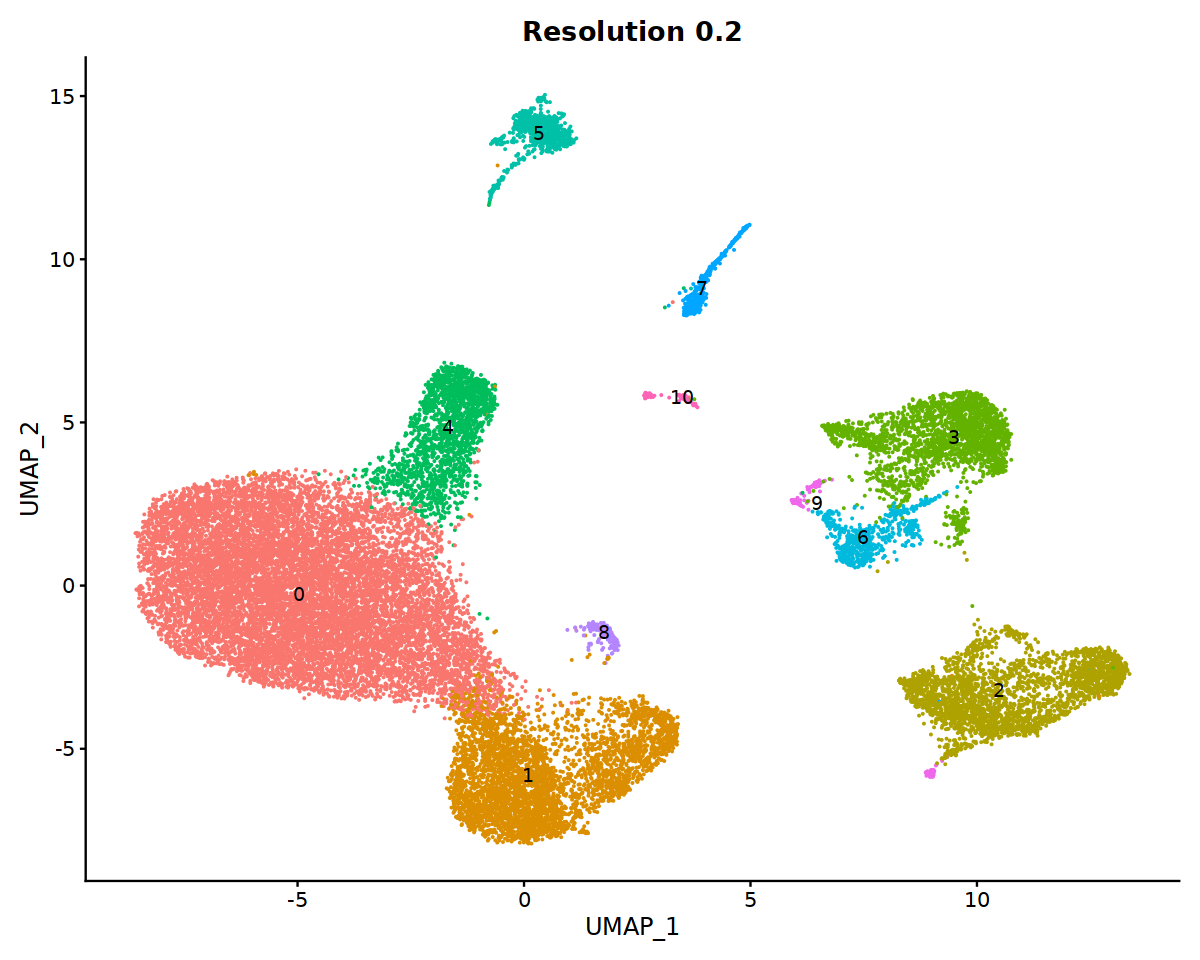

In [57]:
options(repr.plot.width = 10, repr.plot.height = 8, warn=-1,verbose = FALSE)
DimPlot(seurat_obj, reduction = "umap", label = T)+ NoLegend() +
  labs(title=glue("Resolution {reso}")) + theme(plot.title = element_text(hjust = 0.5))

### Compute markers

In [58]:
rna.markers <- FindAllMarkers(seurat_obj, min.pct = 0.1, 
                              logfc.threshold = 0.1, only.pos = T,
                              random.seed=0, max.cells.per.ident=1000)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10



In [59]:
c <- 8
rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head(n=15)

p_val        avg_log2FC pct.1 pct.2 p_val_adj    cluster gene    
SLC8A12   3.443401e-72 2.588615   0.968 0.625 1.002305e-67 8       SLC8A1  
ARHGAP261 9.128107e-65 2.529512   0.968 0.776 2.657009e-60 8       ARHGAP26
LRMDA3    9.202523e-48 2.467604   0.841 0.527 2.678670e-43 8       LRMDA   
JARID21   3.158789e-47 2.422865   0.930 0.761 9.194603e-43 8       JARID2  
DPYD1     1.007175e-72 2.307137   0.975 0.827 2.931685e-68 8       DPYD    
NEAT12    7.314814e-75 2.305020   1.000 0.902 2.129196e-70 8       NEAT1   
PELI21    3.271528e-46 2.286628   0.822 0.461 9.522763e-42 8       PELI2   
ZEB22     2.988112e-69 2.171783   0.987 0.860 8.697798e-65 8       ZEB2    
PLCB12    3.971473e-20 2.162456   0.580 0.346 1.156016e-15 8       PLCB1   
SMAD31    7.956045e-37 2.077389   0.783 0.460 2.315846e-32 8       SMAD3   
DENND1A2  2.771043e-61 2.072301   0.917 0.597 8.065951e-57 8       DENND1A 
TRPS12    1.300772e-25 2.068676   0.662 0.415 3.786286e-21 8       TRPS1   
ETV63     9.361165e-55 2.050245   0.924 0.669 2.724848e-50 8       ETV6    
RUNX13    6.920931e-37 2.048728   0.847 0.679 2.014545e-32 8       RUNX1   
ATP2B12   5.305195e-53 2.035311   0.949 0.778 1.544236e-48 8       ATP2B1

In [60]:
c <- 9
rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head(n=15)

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene     
HIST1H4C5  1.834512e-89 4.765358   1.000 0.470  5.339896e-85 9       HIST1H4C 
HIST1H1B1 2.394320e-205 4.684937   0.986 0.030 6.969388e-201 9       HIST1H1B 
HIST1H3B1 2.774866e-220 3.975747   0.993 0.020 8.077079e-216 9       HIST1H3B 
HIST1H1C5  2.699748e-92 3.742085   0.986 0.336  7.858427e-88 9       HIST1H1C 
HIST1H1D6 2.111906e-108 3.668594   0.972 0.212 6.147336e-104 9       HIST1H1D 
STMN15    9.155465e-140 3.637031   0.944 0.097 2.664973e-135 9       STMN1    
HIST1H1E5  3.360680e-78 3.592984   1.000 0.550  9.782266e-74 9       HIST1H1E 
MKI671    3.043352e-195 3.465913   0.986 0.034 8.858589e-191 9       MKI67    
TUBB7      2.123851e-79 3.435334   0.979 0.550  6.182105e-75 9       TUBB     
HIST1H2AH 3.033119e-205 3.426775   0.972 0.023 8.828803e-201 9       HIST1H2AH
RRM22     1.742660e-209 3.379690   1.000 0.025 5.072536e-205 9       RRM2     
HIST1H3C  9.263310e-183 3.310298   0.880 0.020 2.696364e-178 9       HIST1H3C 
HIST1H2AL 2.102204e-158 3.268380   0.915 0.046 6.119094e-154 9       HIST1H2AL
HMGB23     6.398948e-89 3.213137   1.000 0.465  1.862606e-84 9       HMGB2    
TUBA1B3    4.672883e-77 3.110280   0.993 0.716  1.360183e-72 9       TUBA1B

In [61]:
c <- 10
rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head(n=15)

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene    
IGHA1    9.785855e-175 7.165953   0.758 0.007 2.848467e-170 10      IGHA1   
IGKV3-20  6.025296e-26 6.487524   0.142 0.007  1.753843e-21 10      IGKV3-20
IGKV3-15  6.541197e-14 6.207620   0.100 0.004  1.904012e-09 10      IGKV3-15
IGLV1-40  1.714926e-16 5.610351   0.108 0.006  4.991807e-12 10      IGLV1-40
IGHV3-23  3.379423e-26 5.487772   0.167 0.002  9.836826e-22 10      IGHV3-23
IGLC2     1.258060e-88 5.482482   0.400 0.003  3.661962e-84 10      IGLC2   
IGKC1     8.795233e-89 5.318380   0.550 0.031  2.560116e-84 10      IGKC    
IGHA2     1.104863e-88 5.284894   0.425 0.002  3.216036e-84 10      IGHA2   
IGHV3-30  3.003589e-27 5.241537   0.125 0.000  8.742846e-23 10      IGHV3-30
IGHG1     4.716563e-71 5.019907   0.342 0.003  1.372897e-66 10      IGHG1   
IGHV3-7   1.102278e-21 4.897263   0.100 0.005  3.208510e-17 10      IGHV3-7 
JCHAIN1  1.883281e-140 4.814265   0.792 0.034 5.481856e-136 10      JCHAIN  
IGHM2     1.593293e-47 4.043038   0.375 0.033  4.637756e-43 10      IGHM    
IGHGP     5.492966e-35 3.713795   0.150 0.000  1.598892e-30 10      IGHGP   
MZB12    2.612436e-127 3.706455   0.775 0.041 7.604280e-123 10      MZB1

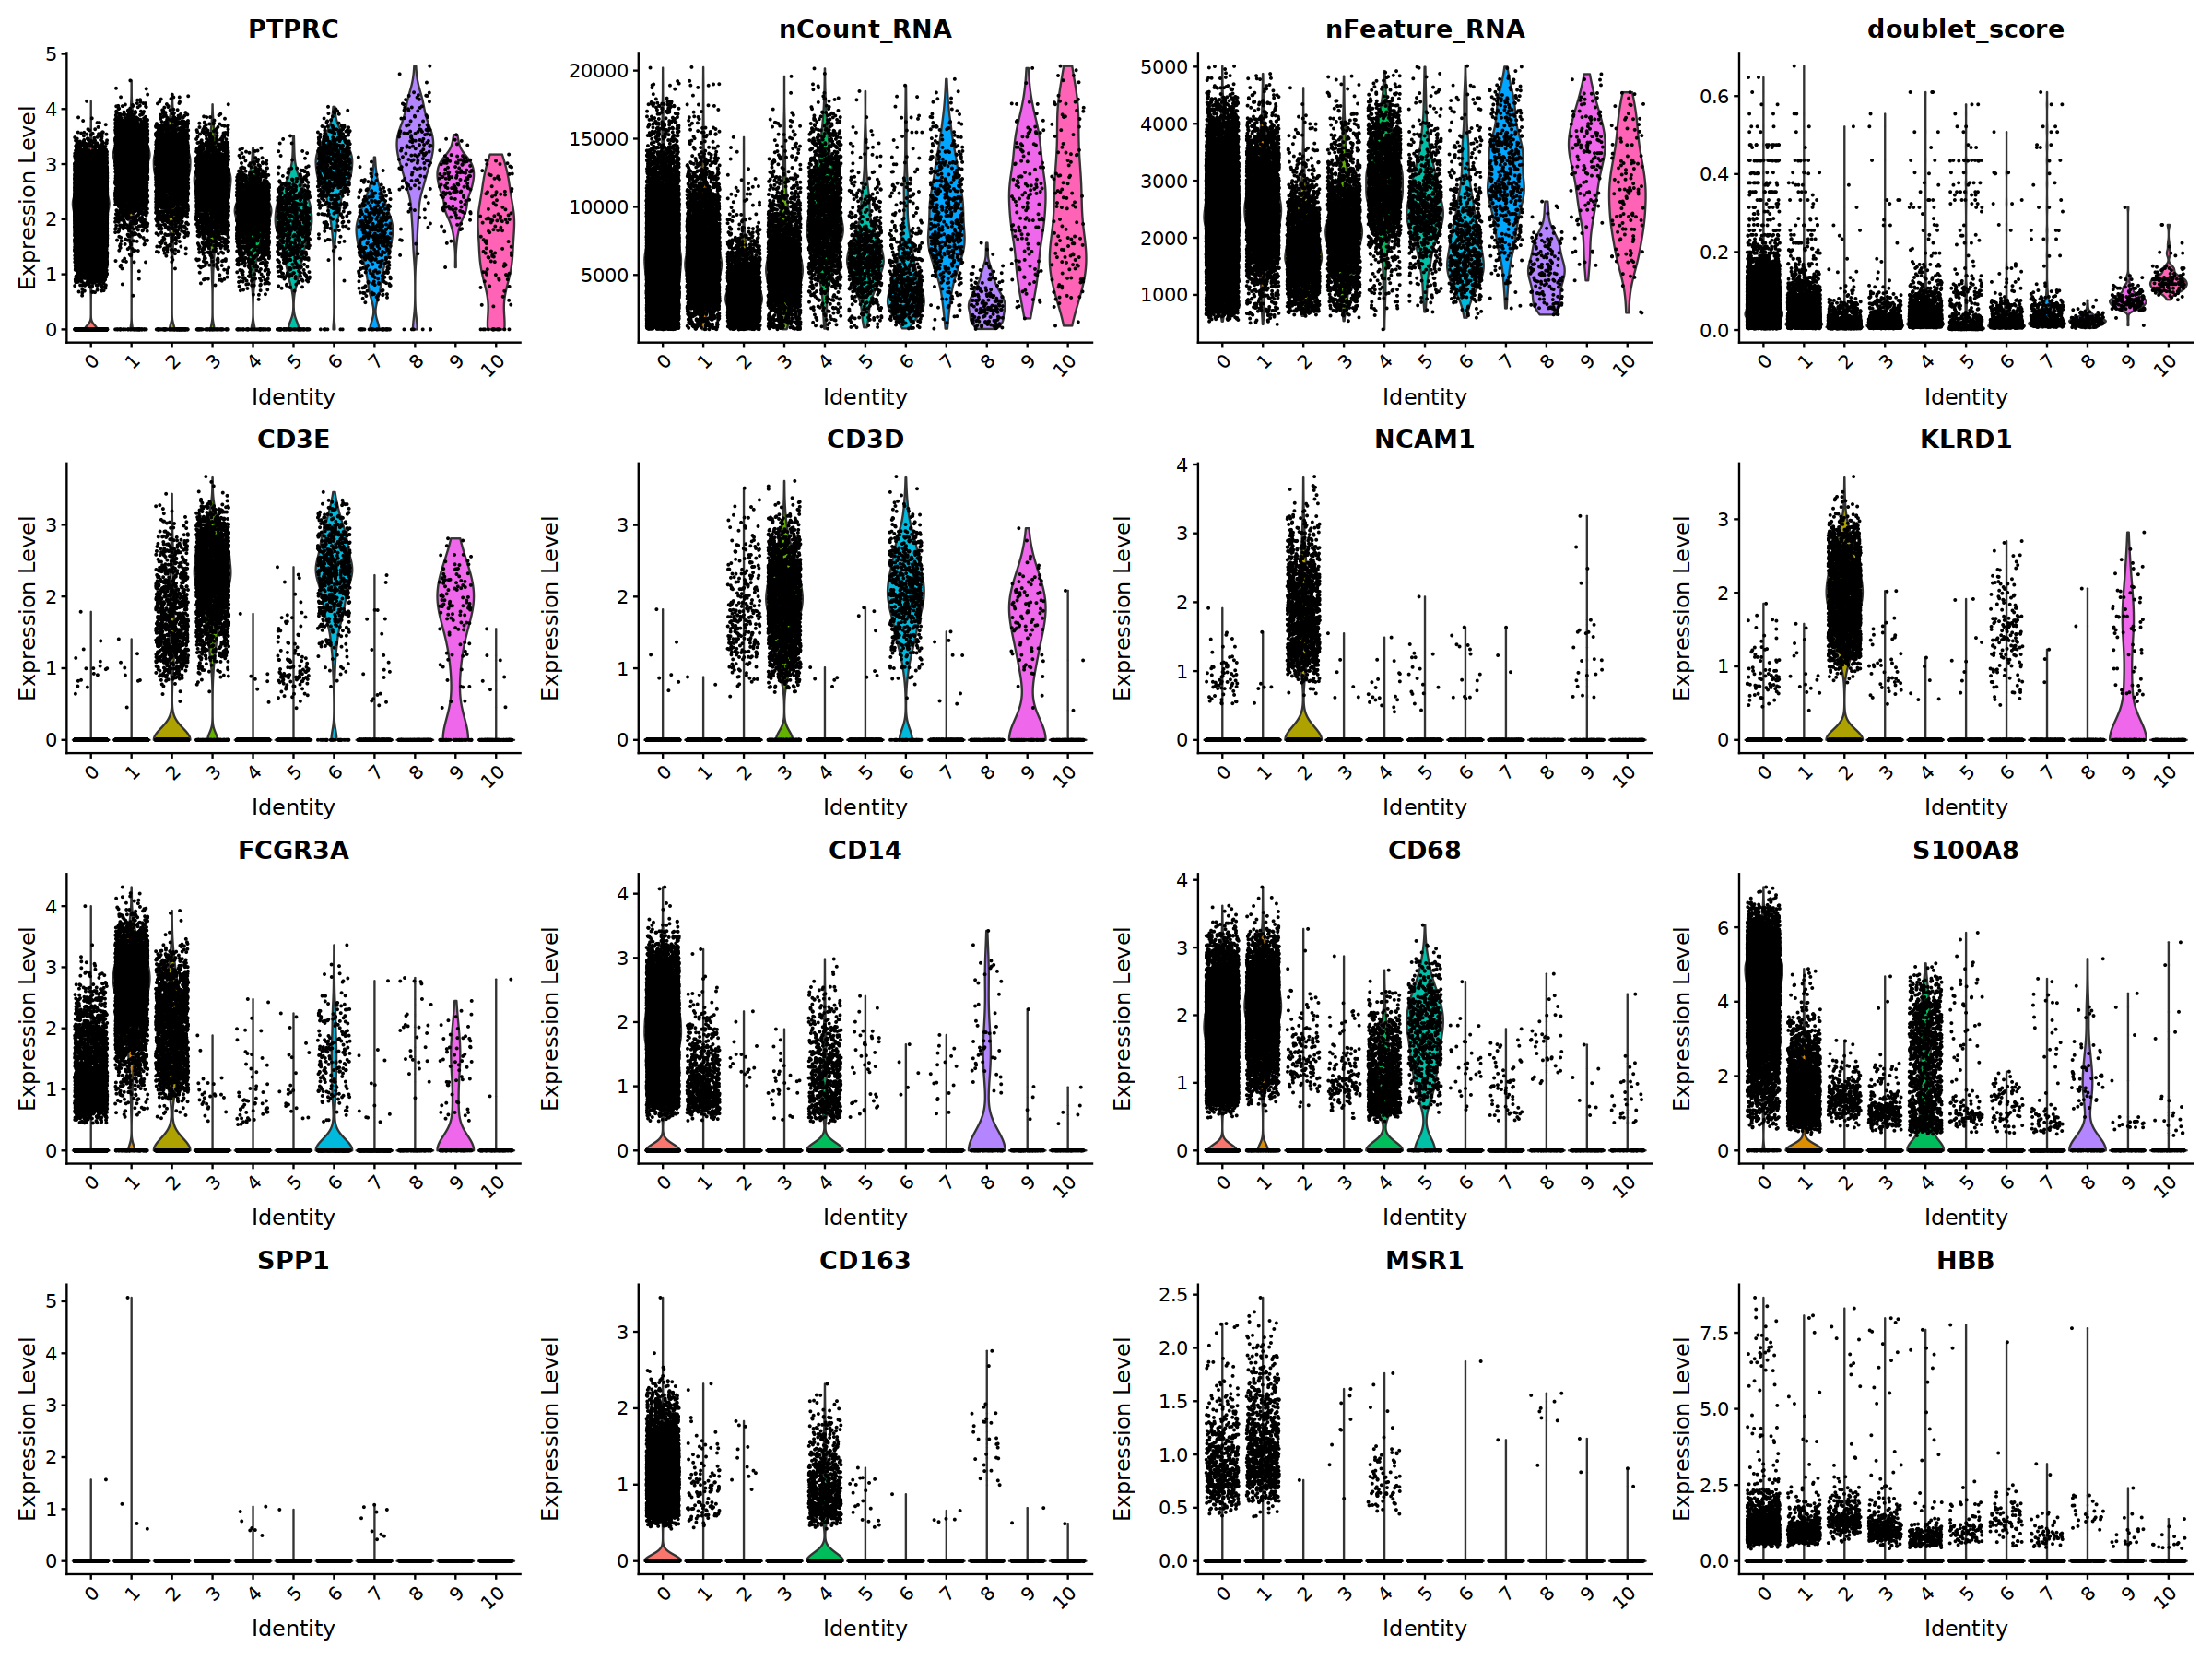

In [62]:
options(repr.plot.width = 20, repr.plot.height = 15, warn=-1,verbose = FALSE)
VlnPlot(seurat_obj, feature=markers, ncol=4)

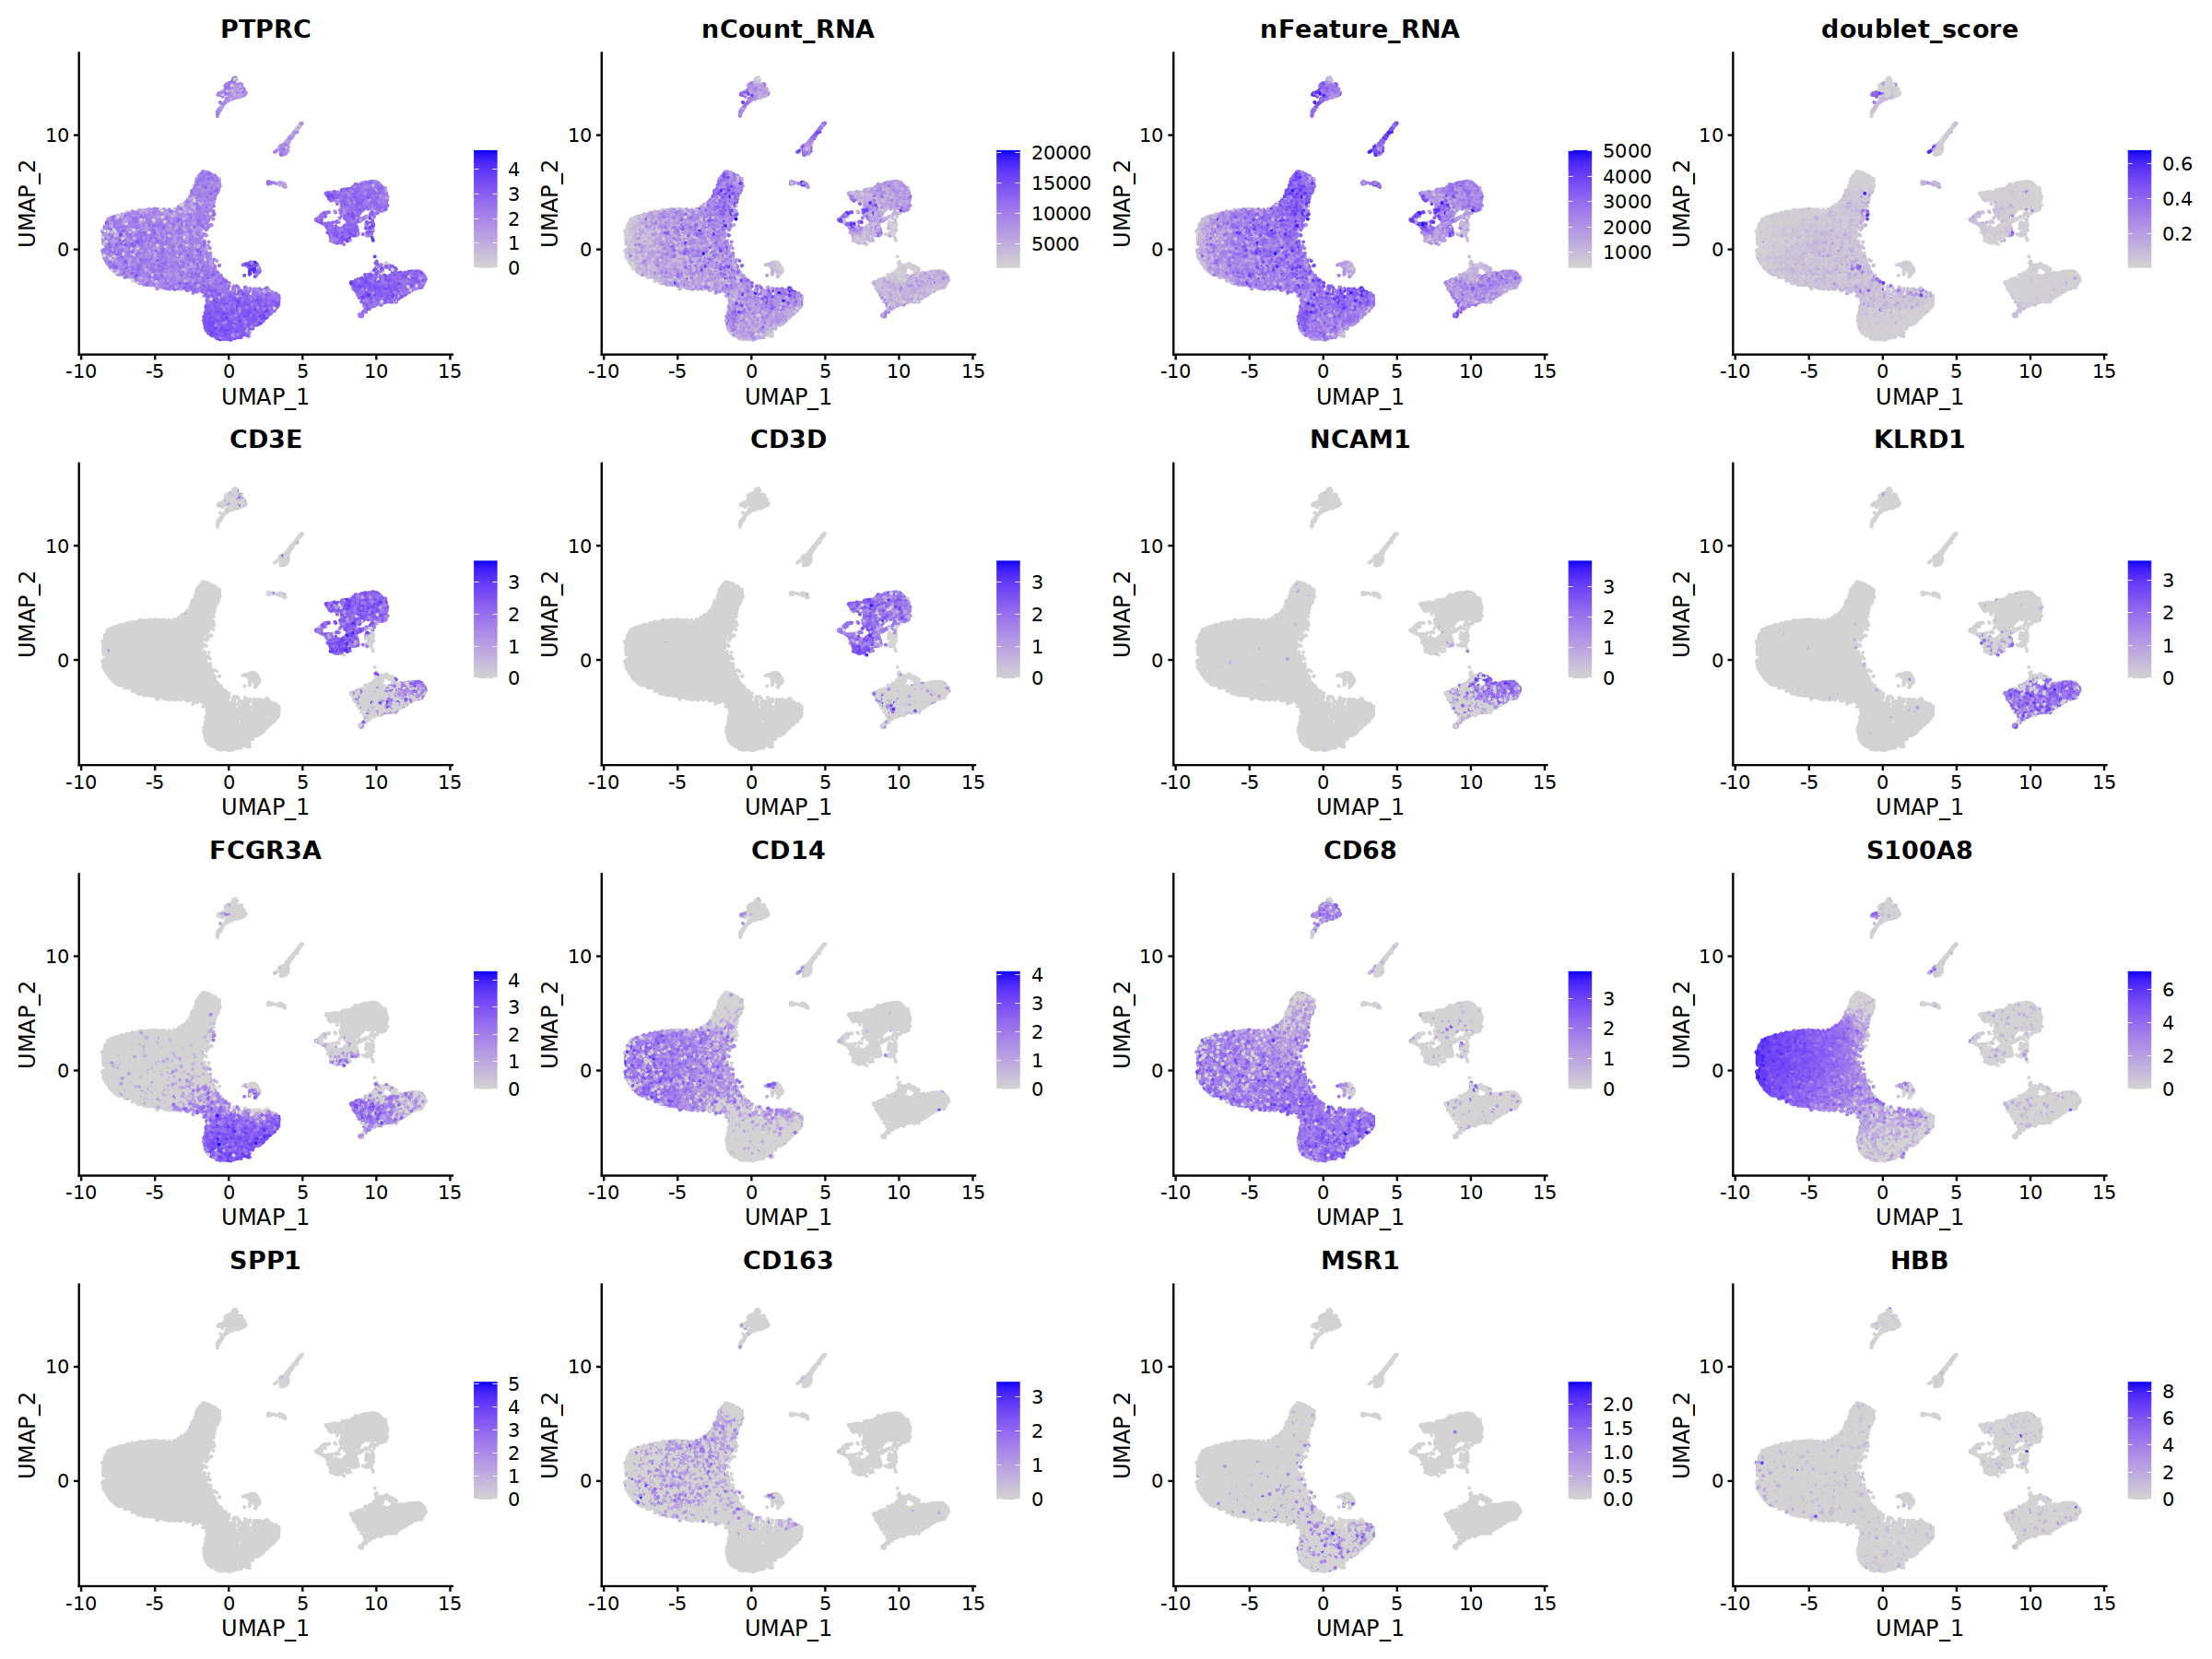

In [63]:
options(repr.plot.width = 20, repr.plot.height = 15, warn=-1,verbose = FALSE)
FeaturePlot(seurat_obj, ncol=4,
            feature=markers)

# Save

In [64]:
saveRDS(seurat_obj, here::here(glue::glue("{clust}/{robj_dir}/3.2-clustering_{timepoint}.rds")))

In [65]:
write_csv(rna.markers, here(glue("{clust}/{robj_dir}/3.2-clustering_{timepoint}.csv")))

# Session Info

In [66]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/groups/singlecell/isentis/conda_envs/ines_r4.1.1c/lib/libopenblasp-r0.3.24.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=es_ES.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=es_ES.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=es_ES.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=es_ES.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] scran_1.22.1                scater_1.22.0              
 [3] scuttle_1.4.0               SingleCellExperiment_1.16.0
 [5] SummarizedExperiment_1.24.0 Biobase_2.54.0             
 [7] GenomicRanges_1.46.1        GenomeInfoDb_1.30.1        
 [9] IRanges_